In [1]:
#install.packages('Metrics')
library('astsa')
library(forecast)
library('Metrics')

options(repr.plot.width=14, repr.plot.height=6)


Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘forecast’


The following object is masked from ‘package:astsa’:

    gas



Attaching package: ‘Metrics’


The following object is masked from ‘package:forecast’:

    accuracy




In [2]:
setwd('./')
ts_df <- read.csv("./data/proyectos_analiticos_20210501-20210531_resampled.csv")
#ts_df <- read.csv("./data/proyectos_analiticos_20210501-20210531_no_weekends_resampled.csv")

In [3]:
ts_df <- ts_df[,2]

x = ts(ts_df, start=0 , frequency=1)


In [4]:
x = x/300000 # paso la unidad a slots

In [5]:
ts_df = ts_df/300000 # paso la unidad a slots

In [6]:
ts_df = ts(ts_df, start=0, frequency=1)

In [7]:
length(ts_df)

[1] 8928

In [8]:
#time(ts_df)

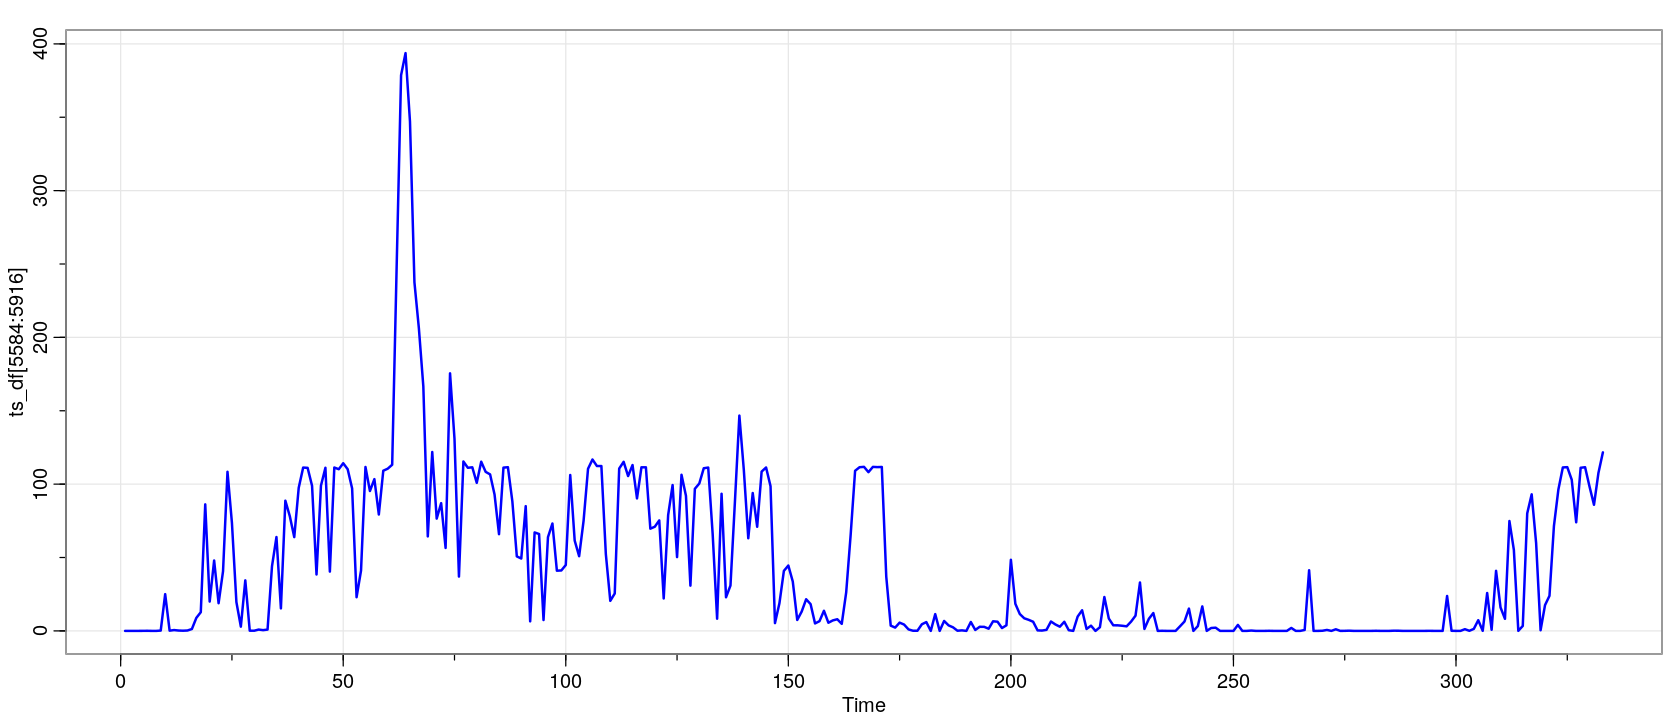

In [9]:
# dias 19 al 21 de mayo (arranca en 18*288=5184)
tsplot(ts_df[5584:5916], col=4, lwd=2)

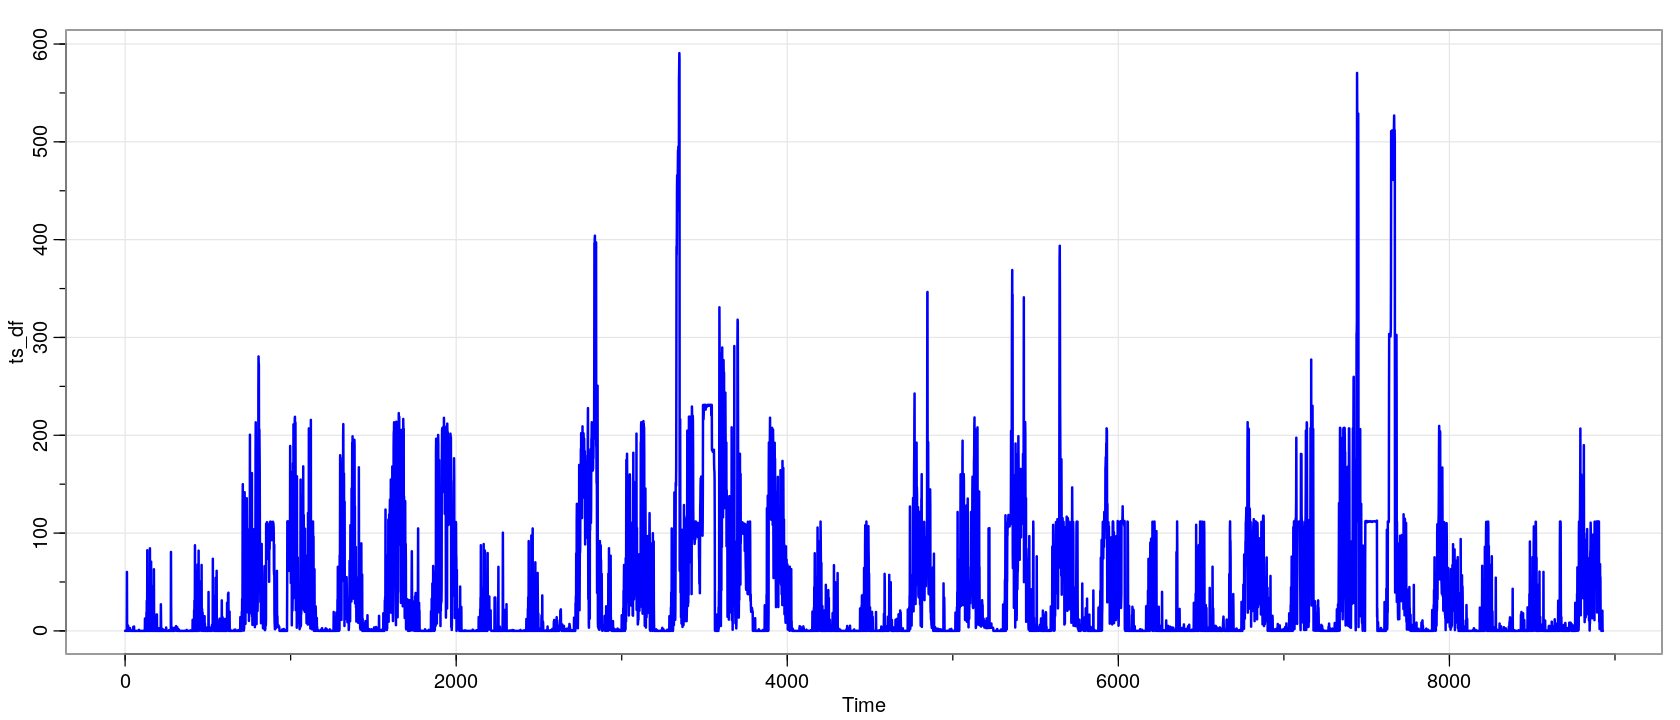

In [10]:
tsplot(ts_df, col=4, lwd=2)

In [11]:

train_predict <- function(start_train, start_test, time_series) {
    
    ret = c(0,0)
    
    ts_length = length(time_series)        
    
    end_train = start_test - 1

    ts_df_train = ts(time_series[start_train:end_train], start=start_train-1, frequency=1)
    ts_df_test = ts(time_series[start_test:ts_length], start=start_test-1, frequency=1)
    
    dn = ts_df_train
    dnt = ts_df_test
    
    # nuevos datos para prediccion
    new_t = seq(start_test-1,start_test-1,by=1)
    new_t = ts(new_t,start=start_test-1,freq=1)
    new_data = data.frame(t=new_t)
    
    # agrego para probar +1 para evitar log(0)
    ldn = log(dn+1)
    ldnt = log(dnt+1)
    t = time(ldn)
    
    fit = lm(ldn ~ t, na.action=NULL)
    
    #ndata <- data.frame(t = start_test-1)
    ndata <- data.frame(t = new_data)
    
    predict_trend = predict(fit,newdata=ndata)
    
    predicttrend = ts(fitted(fit), start=start_train-1, freq=1)
    
    #ldn = as.numeric(ldn)
    ldnc = ldn-predicttrend
    
    ###
    ldnc = ts(ldn-predicttrend, start=start_train-1, freq=1)
    ### 
    
    t = time(ldnc)

    #f1 =  0.000192
    #f2 =  0.000385
    #f3 =  0.000578
    #f4 =  0.000771
    #f5 =  0.000964
    #f6 =  0.001157
    #f7 =  0.002507
    #f8 =  0.002893
    #f9 =  0.003472
    #f10 = 0.004436
    #f11 = 0.006944
    #f12 = 0.010416    
    
    f1 =  0.003473
    f2 =  0.006946
    f3 =  0.010419

    fit = lm(ldnc ~ 0 + cos(2*pi*f1*t) + sin(2*pi*f1*t) +
                        cos(2*pi*f2*t) + sin(2*pi*f2*t) +
                        cos(2*pi*f3*t) + sin(2*pi*f3*t) ,
                        #cos(2*pi*f4*t) + sin(2*pi*f4*t) +
                        #cos(2*pi*f5*t) + sin(2*pi*f5*t) +
                        #cos(2*pi*f6*t) + sin(2*pi*f6*t) +
                        #cos(2*pi*f7*t) + sin(2*pi*f7*t) +
                        #cos(2*pi*f8*t) + sin(2*pi*f8*t) +
                        #cos(2*pi*f9*t) + sin(2*pi*f9*t) +
                        #cos(2*pi*f10*t) + sin(2*pi*f10*t) +
                        #cos(2*pi*f11*t) + sin(2*pi*f11*t) +
                        #cos(2*pi*f12*t) + sin(2*pi*f12*t) ,
             na.action=NULL)
    
    prediction = ts(fitted(fit), start=start_train-1, freq=1)
    
    #tn = ts_length
    tn = start_test - 1 
            
    v = 0 + cos(2*pi*f1*tn) + sin(2*pi*f1*tn) +
            cos(2*pi*f2*tn) + sin(2*pi*f2*tn) +
            cos(2*pi*f3*tn) + sin(2*pi*f3*tn) 
            #cos(2*pi*f4*tn) + sin(2*pi*f4*tn) +
            #cos(2*pi*f5*tn) + sin(2*pi*f5*tn) +
            #cos(2*pi*f6*tn) + sin(2*pi*f6*tn) +
            #cos(2*pi*f7*tn) + sin(2*pi*f7*tn) +
            #cos(2*pi*f8*tn) + sin(2*pi*f8*tn) +
            #cos(2*pi*f9*tn) + sin(2*pi*f9*tn) +
            #cos(2*pi*f10*tn) + sin(2*pi*f10*tn) +
            #cos(2*pi*f11*tn) + sin(2*pi*f11*tn) +
            #cos(2*pi*f12*tn) + sin(2*pi*f12*tn)

    #vdf <- data.frame(t = v)
    
    vdf <- data.frame(t = new_data)
    fore_f = predict(fit, vdf)    

    res = (ts(residuals(fit), start=start_train -1, freq=1))

    ldncr1 = res
        
    fit = Arima(ldncr1, order = c(5,0,0), include.mean=FALSE)
    #fit = Arima(ldncr1, order = c(6,0,0), include.mean=FALSE, 
    #            seasonal = list(order = c(6,0,0), period = 6))
    #fit = Arima(ldncr1, order = c(6,0,6), include.mean=FALSE, 
    #            seasonal = list(order = c(5,0,1), period = 6))
    fore = forecast(fit, h=1)   
    
    ldnt = as.numeric(ldnt)
    
    #e = exp(1)

    ldnt = ts(ldnt, start=start_test -1, frequency=1)    
    
    v_ldnt = ldnt #c + predictiont
    v_pred = fore$mean + fore_f + predict_trend    
    #v_pred = fore_f + predict_trend
    #v_pred = fore_f

    #v_ldnt = (e^v_ldnt) 
    #v_pred = (e^v_pred) -1 
    
    v_ldnt = (exp(v_ldnt)) -1 
    v_pred = (exp(v_pred)) -1 
    
    v_ldnt[1:5]
    v_pred[1:5]
    ret = c(v_ldnt[1], v_pred[1], time(v_ldnt)[1], time(v_pred)[1],fore$mean,fore_f,predict_trend)
    #ret = c(v_ldnt[1], v_pred[1], time(v_ldnt)[1], time(v_pred)[1])
    
    return(ret)
    
}

In [12]:
#testv <- train_predict(6500-6400, 6500, ts_df)
#testv

In [13]:
Sys.time()

[1] "2021-07-24 17:23:11 -03"

In [14]:
start_train = 1
start_test = 5306
# time serie : ts_df
testv <- train_predict(start_train, start_test, ts_df)
print(paste("observed -", "prediction"))
testv

[1] "observed - prediction"


1                                                   1 
   0.0375900    5.5680604 5305.0000000 5305.0000000    0.4979158   -0.8971236 
           1 
   2.2814263

In [15]:
Sys.time()

[1] "2021-07-24 17:23:11 -03"

In [16]:
df_validation <- data.frame(observed=double(), predicted=double(), timeo=integer(), timep=integer())

vect_obs <- c()
vect_pred <- c()

vect_arma <- c()
vect_freq <- c()
vect_tren <- c()
vect_tren_freq <- c()

for (i in (5290:5700)) {   
    print(i)
    #print(paste0("parametros: ", i-5180, " ", i))
    testv <- train_predict(i-5290, i, ts_df)
    print(testv)
    vect_obs <- append(vect_obs, testv[1])
    vect_pred <- append(vect_pred, testv[2])
    vect_arma <- append(vect_arma, testv[5])
    vect_freq <- append(vect_freq, testv[6])
    vect_tren <- append(vect_tren, testv[7])
    vect_tren_freq <- append(vect_tren_freq, testv[6]+testv[7])
    
    
    #print(testv)
    df_validation[nrow(df_validation)+1,] = testv
}

[1] 5290
                        1                                                   1 
   0.0000000    0.2060976 5289.0000000 5288.0000000   -0.3771377   -1.7393524 
           1 
   2.3038801 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5291
                        1                                                   1 
   0.0000000    0.1342113 5290.0000000 5290.0000000   -0.4362433   -1.7399574 
           1 
   2.3021382 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5292
                        1                                                   1 
   0.0000000    0.1396223 5291.0000000 5291.0000000   -0.4660593   -1.7031819 
           1 
   2.2999380 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5293
                        1                                                   1 
   1.4753633    0.1522460 5292.0000000 5292.0000000   -0.4926622   -1.6633640 
           1 
   2.2977393 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5294
                          1                                           
   0.12627667    0.80196575 5293.00000000 5293.00000000   -0.08787819 
            1             1 
  -1.61952612    2.29628246 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5295
                        1                                                   1 
   0.0000000    0.3863201 5294.0000000 5294.0000000   -0.3938727   -1.5736477 
           1 
   2.2941733 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5296
                        1                                                   1 
   0.0000000    0.2902555 5295.0000000 5295.0000000   -0.5121011   -1.5250389 
           1 
   2.2919803 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5297
                          1                                           
 1.133333e-04  3.135676e-01  5.296000e+03  5.296000e+03 -5.433681e-01 
            1             1 
-1.473643e+00  2.289758e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5298
                        1                                                   1 
   0.0000000    0.3417619 5297.0000000 5297.0000000   -0.5740012   -1.4195459 
           1 
   2.2875308 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5299
                        1                                                   1 
   0.0000000    0.2282603 5298.0000000 5298.0000000   -0.7168948   -1.3628426 
           1 
   2.2853362 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5300
                        1                                                   1 
   0.0000000    0.2250367 5299.0000000 5299.0000000   -0.7766279   -1.3036342 
           1 
   2.2832329 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5301
                        1                                                   1 
   0.1103633    0.2379684 5300.0000000 5300.0000000   -0.8256704   -1.2420320 
           1 
   2.2811741 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5302
                        1                                                   1 
   0.0000000    0.3154454 5301.0000000 5301.0000000   -0.8268624   -1.1780408 
           1 
   2.2790785 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5303
                        1                                                   1 
   0.0000000    0.2814482 5302.0000000 5302.0000000   -0.9184342   -1.1119833 
           1 
   2.2784083 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5304
                        1                                                   1 
   0.0000000    0.2886172 5303.0000000 5303.0000000   -0.9793522   -1.0439085 
           1 
   2.2768304 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5305
                        1                                                   1 
  26.9908967    0.3039964 5304.0000000 5304.0000000   -1.0352049   -0.9739662 
           1 
   2.2746048 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5306
                        1                                                   1 
   0.0375900    5.5548340 5305.0000000 5305.0000000    0.5038358   -0.8985315 
           1 
   2.2748985 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5307
                        1                                                   1 
   0.0000000    1.0791035 5306.0000000 5306.0000000   -0.7154974   -0.8252659 
           1 
   2.2727001 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5308
                        1                                                   1 
   0.0000000    0.7815131 5307.0000000 5307.0000000   -0.9423729   -0.7506378 
           1 
   2.2704737 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5309
                          1                                           
 2.233333e-04  8.869383e-01  5.308000e+03  5.308000e+03 -9.585232e-01 
            1             1 
-6.747686e-01  2.268247e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5310
                        1                                                   1 
   0.0000000    0.9662297 5309.0000000 5309.0000000   -0.9928014   -0.5978063 
           1 
   2.2667256 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5311
                        1                                                   1 
   0.0000000    0.3749058 5310.0000000 5310.0000000   -1.4261691   -0.5199454 
           1 
   2.2644996 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5312
                        1                                                   1 
   0.0000000    0.3816420 5311.0000000 5311.0000000   -1.4976475   -0.4413535 
           1 
   2.2622737 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5313
                          1                                           
   0.06651667    0.39365936 5312.00000000 5312.00000000   -1.56590776 
            1             1 
  -0.36220704    2.26004771 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5314
                        1                                                   1 
  30.3594767    0.4495584 5313.0000000 5313.0000000   -1.6040006   -0.2826109 
           1 
   2.2578704 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5315
                          1                                           
   1.23655333    6.48980997 5314.00000000 5314.00000000   -0.04571227 
            1             1 
  -0.19899408    2.25824978 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5316
                        1                                                   1 
  52.0030733    2.3272979 5315.0000000 5315.0000000   -0.9363507   -0.1183537 
           1 
   2.2568650 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5317
                        1                                                   1 
  20.4641333   13.4934527 5316.0000000 5316.0000000    0.4500753   -0.0343009 
           1 
   2.2579226 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5318
                        1                                                   1 
5.951869e+01 1.532859e+01 5.317000e+03 5.317000e+03 4.862439e-01 4.836905e-02 
           1 
2.258304e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5319
                        1                                                   1 
 118.1769467   33.7790529 5318.0000000 5318.0000000    1.1576651    0.1316737 
           1 
   2.2596765 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5320
                        1                                                   1 
  20.9276933   52.1996361 5319.0000000 5319.0000000    1.4976913    0.2150138 
           1 
   2.2613465 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5321
                        1                                                   1 
3.266667e-04 3.570893e+01 5.320000e+03 5.320000e+03 1.045520e+00 2.955322e-01 
           1 
2.261968e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5322
                        1                                                   1 
   0.8265000    6.1110755 5321.0000000 5321.0000000   -0.6697280    0.3714686 
           1 
   2.2599129 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5323
                        1                                                   1 
  34.2246867    5.5696964 5322.0000000 5322.0000000   -0.8227674    0.4468412 
           1 
   2.2583939 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5324
                        1                                                   1 
  31.3226200   19.8521949 5323.0000000 5323.0000000    0.2544564    0.5241454 
           1 
   2.2588574 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5325
                        1                                                   1 
1.699333e+00 1.796301e+01 5.324000e+03 5.324000e+03 8.346541e-02 5.997698e-01 
           1 
2.259255e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5326
                        1                                                   1 
   1.7178933    4.5435309 5325.0000000 5325.0000000   -1.2159890    0.6708458 
           1 
   2.2577749 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5327
                        1                                                   1 
   1.6062333    4.7905937 5326.0000000 5326.0000000   -1.2401118    0.7400471 
           1 
   2.2562995 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5328
                        1                                                   1 
  49.3416800    5.3194483 5327.0000000 5327.0000000   -1.2183392    0.8071789 
           1 
   2.2547922 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5329
                        1                                                   1 
  50.7763767   19.1482695 5328.0000000 5328.0000000   -0.1279100    0.8755047 
           1 
   2.2555236 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5330
                          1                                           
  96.79048000   21.81384710 5329.00000000 5329.00000000   -0.07047819 
            1             1 
   0.94157041    2.25627546 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5331
                        1                                                   1 
  97.1630333   38.7963893 5330.0000000 5330.0000000    0.4201679    1.0059433 
           1 
   2.2576650 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5332
                        1                                                   1 
 109.9918900   57.6141787 5331.0000000 5331.0000000    0.7442928    1.0677850 
           1 
   2.2588988 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5333
                      1                                               1 
 105.288497   90.208560 5332.000000 5332.000000    1.125802    1.127123 
          1 
   2.260224 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5334
                      1                                               1 
 110.802893   96.221242 5333.000000 5333.000000    1.131804    1.183669 
          1 
   2.261516 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5335
                      1                                               1 
 111.315953  106.338992 5334.000000 5334.000000    1.175708    1.237439 
          1 
   2.262846 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5336
                      1                                               1 
 115.480163  108.247841 5335.000000 5335.000000    1.141142    1.288300 
          1 
   2.264177 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5337
                      1                                               1 
 118.507873  111.625196 5336.000000 5336.000000    1.122312    1.336219 
          1 
   2.265535 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5338
                      1                                               1 
 115.588737  113.502711 5337.000000 5337.000000    1.092541    1.381121 
          1 
   2.266936 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5339
                      1                                               1 
 108.428300  113.351458 5338.000000 5338.000000    1.048084    1.422900 
          1 
   2.268293 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5340
                        1                                                   1 
 109.7416033  110.0127617 5339.0000000 5339.0000000    0.9785542    1.4614724 
           1 
   2.2696186 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5341
                        1                                                   1 
 110.5476433  109.9615585 5340.0000000 5340.0000000    0.9407323    1.4969094 
           1 
   2.2715421 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5342
                      1                                               1 
 110.909250  109.642814 5341.000000 5341.000000    0.904277    1.529167 
          1 
   2.272863 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5343
                        1                                                   1 
 110.1075733  108.6573449 5342.0000000 5342.0000000    0.8649375    1.5582380 
           1 
   2.2741849 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5344
                        1                                                   1 
 106.7923300  107.3749294 5343.0000000 5343.0000000    0.8259847    1.5841114 
           1 
   2.2755006 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5345
                        1                                                   1 
 112.0768567  105.5412437 5344.0000000 5344.0000000    0.7845955    1.6067835 
           1 
   2.2771532 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5346
                        1                                                   1 
 113.2063600  107.2212095 5345.0000000 5345.0000000    0.7786813    1.6263708 
           1 
   2.2791252 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5347
                        1                                                   1 
 113.4146400  107.6240068 5346.0000000 5346.0000000    0.7645886    1.6428445 
           1 
   2.2804593 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5348
                        1                                                   1 
 113.1120167  107.3685812 5347.0000000 5347.0000000    0.7475018    1.6562428 
           1 
   2.2817936 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5349
                        1                                                   1 
 113.4901900  106.9899120 5348.0000000 5348.0000000    0.7323007    1.6666121 
           1 
   2.2831250 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5350
                        1                                                   1 
 109.6708700  107.2716049 5349.0000000 5349.0000000    0.7261649    1.6740202 
           1 
   2.2844579 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5351
                      1                                               1 
 109.189693  105.120123 5350.000000 5350.000000    0.700313    1.678495 
          1 
   2.285764 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5352
                        1                                                   1 
 141.7463000  103.8898943 5351.0000000 5351.0000000    0.6856975    1.6801477 
           1 
   2.2870659 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5353
                        1                                                   1 
 204.5374967  116.7898105 5352.0000000 5352.0000000    0.8009754    1.6793638 
           1 
   2.2885625 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5354
                      1                                               1 
 202.502173  142.953233 5353.000000 5353.000000    1.002799    1.676356 
          1 
   2.290334 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5355
                      1                                               1 
 203.361640  151.051513 5354.000000 5354.000000    1.061322    1.670801 
          1 
   2.292096 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5356
                      1                                               1 
 203.290787  159.091008 5355.000000 5355.000000    1.119060    1.662822 
          1 
   2.293861 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5357
                      1                                               1 
 206.268623  168.901324 5356.000000 5356.000000    1.187066    1.652528 
          1 
   2.295624 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5358
                      1                                               1 
 297.324670  175.942391 5357.000000 5357.000000    1.238372    1.640056 
          1 
   2.297397 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5359
                      1                                               1 
 341.278190  209.017109 5358.000000 5358.000000    1.421819    1.625926 
          1 
   2.299444 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5360
                      1                                               1 
 368.925507  233.471602 5359.000000 5359.000000    1.545730    1.610010 
          1 
   2.301594 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5361
                      1                                               1 
 259.881977  253.516143 5360.000000 5360.000000    1.643187    1.592376 
          1 
   2.303801 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5362
                      1                                               1 
 343.705397  226.256775 5361.000000 5361.000000    1.547662    1.572675 
          1 
   2.305744 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5363
                      1                                               1 
  78.973803  261.475238 5362.000000 5362.000000    1.710502    1.551760 
          1 
   2.307895 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5364
                      1                                               1 
  64.087013  132.048349 5363.000000 5363.000000    1.053966    1.527806 
          1 
   2.308941 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5365
                        1                                                   1 
  71.3060000   97.6435487 5364.0000000 5364.0000000    0.7792449    1.5023853 
           1 
   2.3098826 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5366
                        1                                                   1 
  80.5124000   87.1429196 5365.0000000 5365.0000000    0.6921113    1.4759981 
           1 
   2.3108502 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5367
                      1                                               1 
  81.686400   81.303765 5366.000000 5366.000000    0.649697    1.448812 
          1 
   2.311907 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5368
                        1                                                   1 
  82.9498367   69.5895093 5367.0000000 5367.0000000    0.5230477    1.4208593 
           1 
   2.3129745 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5369
                        1                                                   1 
 158.1321767   69.8166970 5368.0000000 5368.0000000    0.5537528    1.3922899 
           1 
   2.3140522 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5370
                        1                                                   1 
  23.5143533   97.6465277 5369.0000000 5369.0000000    0.9119588    1.3639594 
           1 
   2.3156248 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5371
                        1                                                   1 
  83.1046033   43.0455762 5370.0000000 5370.0000000    0.1362813    1.3331740 
           1 
   2.3157697 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5372
                        1                                                   1 
 126.2374300   64.8818276 5371.0000000 5371.0000000    0.5674222    1.3035945 
           1 
   2.3168460 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5373
                        1                                                   1 
 139.9669000   85.1699122 5372.0000000 5372.0000000    0.8636518    1.2744349 
           1 
   2.3182344 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5374
                        1                                                   1 
 123.6291400   92.6265118 5373.0000000 5373.0000000    0.9741343    1.2454801 
           1 
   2.3196992 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5375
                      1                                               1 
 147.454680   84.339062 5374.000000 5374.000000    0.908954    1.216608 
          1 
   2.321070 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5376
                      1                                               1 
 159.487647  108.755253 5375.000000 5375.000000    1.187113    1.188294 
          1 
   2.322846 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5377
                      1                                               1 
 122.157463  120.782819 5376.000000 5376.000000    1.317291    1.160542 
          1 
   2.324406 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5378
                      1                                               1 
   3.463040  108.554030 5377.000000 5377.000000    1.237567    1.133087 
          1 
   2.325765 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5379
                        1                                                   1 
  68.3833233   20.5626566 5378.0000000 5378.0000000   -0.3562388    1.1025882 
           1 
   2.3246136 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5380
                      1                                               1 
 191.574110   51.674216 5379.000000 5379.000000    0.562566    1.076023 
          1 
   2.325537 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5381
                      1                                               1 
 122.348007   90.656572 5380.000000 5380.000000    1.139277    1.051540 
          1 
   2.327231 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5382
                        1                                                   1 
 181.2511700   72.5136377 5381.0000000 5381.0000000    0.9413125    1.0275707 
           1 
   2.3285877 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5383
                      1                                               1 
  26.019107   82.976087 5382.000000 5382.000000    1.095146    1.005148 
          1 
   2.330238 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5384
                        1                                                   1 
  86.8495733   49.8327148 5383.0000000 5383.0000000    0.6163480    0.9817478 
           1 
   2.3304443 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5385
                        1                                                   1 
  87.9047467   76.3490987 5384.0000000 5384.0000000    1.0558434    0.9609408 
           1 
   2.3315447 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5386
                      1                                               1 
  11.147557   75.674942 5385.000000 5385.000000    1.065457    0.941468 
          1 
   2.332650 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5387
                        1                                                   1 
1.709330e+01 2.698616e+01 5.386000e+03 5.386000e+03 7.834146e-02 9.211201e-01 
           1 
2.332249e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5388
                        1                                                   1 
  57.2059900   22.9373721 5387.0000000 5387.0000000   -0.0594051    0.9026549 
           1 
   2.3321912 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5389
                        1                                                   1 
  60.2269867   41.7243835 5388.0000000 5388.0000000    0.5348131    0.8869829 
           1 
   2.3329738 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5390
                        1                                                   1 
 114.7420967   42.1789465 5389.0000000 5389.0000000    0.5586905    0.8728687 
           1 
   2.3337938 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5391
                        1                                                   1 
  42.5895300   53.6091855 5390.0000000 5390.0000000    0.8041111    0.8609966 
           1 
   2.3350944 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5392
                        1                                                   1 
  60.1945967   42.8465626 5391.0000000 5391.0000000    0.5954883    0.8495525 
           1 
   2.3356556 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5393
                        1                                                   1 
  60.2582700   53.9838441 5392.0000000 5392.0000000    0.8305359    0.8400311 
           1 
   2.3364724 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5394
                        1                                                   1 
  65.3782833   55.9318783 5393.0000000 5393.0000000    0.8725212    0.8320450 
           1 
   2.3372892 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5395
                        1                                                   1 
 116.3188300   58.3225214 5394.0000000 5394.0000000    0.9191522    0.8256710 
           1 
   2.3381658 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5396
                      1                                               1 
 162.719683   72.483910 5395.000000 5395.000000    1.136153    0.821441 
          1 
   2.339472 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5397
                        1                                                   1 
 199.0671967   96.3905789 5396.0000000 5396.0000000    1.4186442    0.8190558 
           1 
   2.3410295 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5398
                        1                                                   1 
 177.0191200  117.8381018 5397.0000000 5397.0000000    1.6166996    0.8183251 
           1 
   2.3427373 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5399
                      1                                               1 
 150.168807  126.111981 5398.000000 5398.000000    1.681871    0.818842 
          1 
   2.344356 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5400
                        1                                                   1 
  92.0944400  128.9960701 5399.0000000 5399.0000000    1.7011080    0.8205004 
           1 
   2.3458959 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5401
                        1                                                   1 
 127.3162900  104.9238003 5400.0000000 5400.0000000    1.4928238    0.8228743 
           1 
   2.3470219 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5402
                        1                                                   1 
  88.0809267  115.0467302 5401.0000000 5401.0000000    1.5787943    0.8268091 
           1 
   2.3483896 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5403
                        1                                                   1 
 113.6852033   93.8719823 5402.0000000 5402.0000000    1.3715934    0.8314546 
           1 
   2.3494803 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5404
                      1                                               1 
 111.597863   97.463767 5403.000000 5403.000000    1.401496    0.837431 
          1 
   2.350761 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5405
                        1                                                   1 
  72.6725567   95.0467638 5404.0000000 5404.0000000    1.3684620    0.8443462 
           1 
   2.3520270 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5406
                      1                                               1 
 131.797670   78.871609 5405.000000 5405.000000    1.175798    0.851651 
          1 
   2.352971 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5407
                        1                                                   1 
 125.4939767   98.0507742 5406.0000000 5406.0000000    1.3808741    0.8603986 
           1 
   2.3543599 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5408
                        1                                                   1 
 145.2980267  102.7248531 5407.0000000 5407.0000000    1.4162636    0.8697674 
           1 
   2.3557108 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5409
                        1                                                   1 
 129.5695267  110.3346309 5408.0000000 5408.0000000    1.4754956    0.8798741 
           1 
   2.3571706 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5410
                        1                                                   1 
 142.8235167  107.5901093 5409.0000000 5409.0000000    1.4387177    0.8903193 
           1 
   2.3585434 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5411
                        1                                                   1 
 165.6046767  119.7681995 5410.0000000 5410.0000000    1.5326523    0.9012325 
           1 
   2.3599882 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5412
                        1                                                   1 
 156.2620767  130.5752673 5411.0000000 5411.0000000    1.6044606    0.9125866 
           1 
   2.3625318 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5413
                        1                                                   1 
  95.6347367  131.3253624 5412.0000000 5412.0000000    1.5972163    0.9240049 
           1 
   2.3640426 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5414
                        1                                                   1 
 136.7920667  103.9835384 5413.0000000 5413.0000000    1.3537229    0.9348966 
           1 
   2.3651840 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5415
                        1                                                   1 
 139.2306867  118.5574439 5414.0000000 5414.0000000    1.4711026    0.9461016 
           1 
   2.3665928 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5416
                        1                                                   1 
 152.9986233  121.5953510 5415.0000000 5415.0000000    1.4837511    0.9571243 
           1 
   2.3680138 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5417
                        1                                                   1 
 142.6147267  124.3697297 5416.0000000 5416.0000000    1.4938250    0.9679377 
           1 
   2.3695045 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5418
                      1                                               1 
 117.585087  119.754588 5417.000000 5417.000000    1.444574    0.978245 
          1 
   2.370941 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5419
                        1                                                   1 
 151.9224700  113.6241991 5418.0000000 5418.0000000    1.3816283    0.9877983 
           1 
   2.3722323 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5420
                        1                                                   1 
 136.7572533  126.1593008 5419.0000000 5419.0000000    1.4747312    0.9969948 
           1 
   2.3737146 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5421
                      1                                               1 
 111.761727  122.267900 5420.000000 5420.000000    1.432761    1.005354 
          1 
   2.376246 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5422
                      1                                               1 
 109.682963  108.698007 5421.000000 5421.000000    1.307402    1.012633 
          1 
   2.377696 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5423
                      1                                               1 
 128.046253  104.535556 5422.000000 5422.000000    1.259828    1.018980 
          1 
   2.380240 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5424
                      1                                               1 
 143.245800  112.346814 5423.000000 5423.000000    1.323434    1.024479 
          1 
   2.382539 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5425
                      1                                               1 
 181.001007  116.791999 5424.000000 5424.000000    1.355264    1.028992 
          1 
   2.384664 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5426
                      1                                               1 
 163.872903  131.126272 5425.000000 5425.000000    1.463210    1.032600 
          1 
   2.387948 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5427
                      1                                               1 
 151.861023  131.523242 5426.000000 5426.000000    1.462122    1.034808 
          1 
   2.389829 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5428
                      1                                               1 
 113.012583  131.021804 5427.000000 5427.000000    1.456092    1.035569 
          1 
   2.391306 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5429
                      1                                               1 
 219.249080  115.276304 5428.000000 5428.000000    1.328836    1.034573 
          1 
   2.392560 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5430
                      1                                               1 
 341.026070  154.328838 5429.000000 5429.000000    1.617224    1.032865 
          1 
   2.395456 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5431
                      1                                               1 
  49.811283  198.795558 5430.000000 5430.000000    1.869654    1.030102 
          1 
   2.397539 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5432
                      1                                               1 
  61.254463   83.951339 5431.000000 5431.000000    1.020311    1.023588 
          1 
   2.398179 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5433
                        1                                                   1 
 102.2753700   77.6441476 5432.0000000 5432.0000000    0.9502858    1.0156735 
           1 
   2.3989740 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5434
                      1                                               1 
 104.121607   97.577074 5433.000000 5433.000000    1.184015    1.006667 
          1 
   2.400156 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5435
                        1                                                   1 
 113.0210967   91.7687441 5434.0000000 5434.0000000    1.1327773    0.9959889 
           1 
   2.4013436 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5436
                        1                                                   1 
  99.2895067   82.0546258 5435.0000000 5435.0000000    1.0317579    0.9837297 
           1 
   2.4040109 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5437
                        1                                                   1 
  59.8970733   83.7148646 5436.0000000 5436.0000000    1.0634079    0.9696237 
           1 
   2.4062594 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5438
                        1                                                   1 
 213.5075133   68.5595199 5437.0000000 5437.0000000    0.8806556    0.9532570 
           1 
   2.4082702 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5439
                        1                                                   1 
 201.2886267  118.3422347 5438.0000000 5438.0000000    1.4346053    0.9366121 
           1 
   2.4107779 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5440
                        1                                                   1 
 126.3951167  128.5308453 5439.0000000 5439.0000000    1.5329577    0.9181977 
           1 
   2.4127636 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5441
                        1                                                   1 
  83.2292033  105.6890184 5440.0000000 5440.0000000    1.3582559    0.8975694 
           1 
   2.4140929 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5442
                        1                                                   1 
  88.9873267   86.5656696 5441.0000000 5441.0000000    1.1807428    0.8748554 
           1 
   2.4167907 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5443
                        1                                                   1 
 135.6830967   92.7448966 5442.0000000 5442.0000000    1.2715433    0.8505924 
           1 
   2.4184415 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5444
                      1                                               1 
   9.287067  104.420705 5443.000000 5443.000000    1.412119    0.825233 
          1 
   2.420607 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5445
                        1                                                   1 
  12.0593567   27.8722797 5444.0000000 5444.0000000    0.1474483    0.7954023 
           1 
   2.4200313 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5446
                          1                                           
  83.98054667   22.20440054 5445.00000000 5445.00000000   -0.04001721 
            1             1 
   0.76437375    2.41998540 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5447
                        1                                                   1 
  73.7439233   48.3417822 5446.0000000 5446.0000000    0.7429987    0.7340656 
           1 
   2.4217069 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5448
                        1                                                   1 
  31.6153400   47.1468454 5447.0000000 5447.0000000    0.7479085    0.7022944 
           1 
   2.4240528 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5449
                        1                                                   1 
  73.6536500   27.6028276 5448.0000000 5448.0000000    0.2591996    0.6683413 
           1 
   2.4259647 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5450
                        1                                                   1 
  29.5961167   45.9759662 5449.0000000 5449.0000000    0.7873582    0.6341519 
           1 
   2.4281260 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5451
                        1                                                   1 
  19.9469233   36.9829068 5450.0000000 5450.0000000    0.6100805    0.5978550 
           1 
   2.4292007 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5452
                        1                                                   1 
  27.5948000   26.4318681 5451.0000000 5451.0000000    0.3214558    0.5601284 
           1 
   2.4301212 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5453
                        1                                                   1 
  29.2574600   26.7293571 5452.0000000 5452.0000000    0.3703548    0.5218204 
           1 
   2.4303165 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5454
                        1                                                   1 
  59.0691900   27.5288645 5453.0000000 5453.0000000    0.4367988    0.4827663 
           1 
   2.4313512 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5455
                        1                                                   1 
  58.2995900   34.7259256 5454.0000000 5454.0000000    0.7000207    0.4437491 
           1 
   2.4321068 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5456
                        1                                                   1 
  37.2165067   37.2351406 5455.0000000 5455.0000000    0.8068149    0.4040828 
           1 
   2.4328573 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5457
                        1                                                   1 
  33.3221133   32.9493247 5456.0000000 5456.0000000    0.7280506    0.3633901 
           1 
   2.4334282 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5458
                        1                                                   1 
   5.0065933   31.7545167 5457.0000000 5457.0000000    0.7331369    0.3221458 
           1 
   2.4337581 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5459
                          1                                           
   1.32573667   13.31663306 5458.00000000 5458.00000000   -0.05001877 
            1             1 
   0.27860934    2.43283144 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5460
                        1                                                   1 
  23.3673133    5.8540100 5459.0000000 5459.0000000   -0.7415759    0.2338299 
           1 
   2.4325799 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5461
                        1                                                   1 
1.742731e+01 1.422104e+01 5.460000e+03 5.460000e+03 9.702202e-02 1.916421e-01 
           1 
2.434015e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5462
                        1                                                   1 
  38.7822600   12.5019982 5461.0000000 5461.0000000    0.0189064    0.1491675 
           1 
   2.4347638 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5463
                        1                                                   1 
  96.9342267   16.5169180 5462.0000000 5462.0000000    0.3202567    0.1076825 
           1 
   2.4352279 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5464
                        1                                                   1 
  39.9108100   32.1266025 5463.0000000 5463.0000000    0.9965432    0.0674441 
           1 
   2.4363494 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5465
                        1                                                   1 
   5.7684900   31.7055121 5464.0000000 5464.0000000    1.0241889    0.0265449 
           1 
   2.4368098 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5466
                          1                                           
   0.00000000   12.90205428 5465.00000000 5465.00000000    0.21047272 
            1             1 
  -0.01591835    2.43748225 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5467
                          1                                           
   5.69624333    3.79315255 5466.00000000 5466.00000000   -0.80883552 
            1             1 
  -0.05999586    2.43601972 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5468
                        1                                                   1 
  11.6146367    7.1064433 5467.0000000 5467.0000000   -0.2412181   -0.1012831 
           1 
   2.4351603 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5469
                        1                                                   1 
   7.1576500    7.9292840 5468.0000000 5468.0000000   -0.1043479   -0.1411154 
           1 
   2.4347996 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5470
                        1                                                   1 
   5.1696600    5.3027851 5469.0000000 5469.0000000   -0.4124392   -0.1806157 
           1 
   2.4340465 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5471
                        1                                                   1 
   0.0000000    4.4299233 5470.0000000 5470.0000000   -0.5216366   -0.2195197 
           1 
   2.4330813 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5472
                        1                                                   1 
   5.5291967    1.7176377 5471.0000000 5471.0000000   -1.1725989   -0.2594575 
           1 
   2.4318195 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5473
                        1                                                   1 
   7.4091967    4.3625940 5472.0000000 5472.0000000   -0.4552498   -0.2962006 
           1 
   2.4308981 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5474
                          1                                           
   0.04775667    5.04096161 5473.00000000 5473.00000000   -0.30010751 
            1             1 
  -0.33150809    2.43017880 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5475
                        1                                                   1 
  42.5078933    1.1700053 5474.0000000 5474.0000000   -1.2851789   -0.3679579 
           1 
   2.4278664 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5476
                        1                                                   1 
  10.6235167    9.2718784 5475.0000000 5475.0000000    0.2999524   -0.3989141 
           1 
   2.4283716 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5477
                        1                                                   1 
   0.0672700    8.0234515 5476.0000000 5476.0000000    0.2019909   -0.4300421 
           1 
   2.4278780 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5478
                          1                                           
   0.06377667    1.83353854 5477.00000000 5477.00000000   -0.92154921 
            1             1 
  -0.46250272    2.42557823 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5479
                        1                                                   1 
   1.5414333    1.1384790 5478.0000000 5478.0000000   -1.1696295   -0.4935516 
           1 
   2.4232759 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5480
                        1                                                   1 
  24.5089867    2.4448217 5479.0000000 5479.0000000   -0.6625962   -0.5221638 
           1 
   2.4216322 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5481
                        1                                                   1 
   0.1409767    7.0169672 5480.0000000 5480.0000000    0.2065188   -0.5466907 
           1 
   2.4217321 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5482
                          1                                           
 9.463333e-03  9.840620e-01  5.481000e+03  5.481000e+03 -1.161092e+00 
            1             1 
-5.732440e-01  2.419482e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5483
                        1                                                   1 
   0.1013900    0.7122938 5482.0000000 5482.0000000   -1.2808768   -0.5984283 
           1 
   2.4171390 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5484
                        1                                                   1 
   2.6658900    0.8335178 5483.0000000 5483.0000000   -1.1877465   -0.6219692 
           1 
   2.4159521 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5485
                        1                                                   1 
   0.4683933    2.0855604 5484.0000000 5484.0000000   -0.6452414   -0.6426408 
           1 
   2.4146155 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5486
                        1                                                   1 
  71.7810867    0.6357261 5485.0000000 5485.0000000   -1.2576272   -0.6628423 
           1 
   2.4125563 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5487
                        1                                                   1 
 111.7827967    9.7297466 5486.0000000 5486.0000000    0.6367107   -0.6771393 
           1 
   2.4134485 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5488
                        1                                                   1 
  98.6111933   21.7554015 5487.0000000 5487.0000000    1.3996218   -0.6894903 
           1 
   2.4146710 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5489
                          1                                           
 4.173333e-03  3.262765e+01  5.488000e+03  5.488000e+03  1.800123e+00 
            1             1 
-7.005726e-01  2.415799e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5490
                        1                                                   1 
   0.0000000    3.9560646 5489.0000000 5489.0000000   -0.0973459   -0.7154913 
           1 
   2.4134492 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5491
                        1                                                   1 
  13.4665467    3.4079121 5490.0000000 5490.0000000   -0.1986089   -0.7290865 
           1 
   2.4110966 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5492
                        1                                                   1 
   0.6678067   10.1919523 5491.0000000 5491.0000000    0.7428120   -0.7383813 
           1 
   2.4107642 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5493
                          1                                           
   0.06931667    2.34241988 5492.00000000 5492.00000000   -0.45319639 
            1             1 
  -0.74890631    2.40879776 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5494
                        1                                                   1 
   0.0000000    0.6052104 5493.0000000 5493.0000000   -1.1744607   -0.7587796 
           1 
   2.4064951 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5495
                        1                                                   1 
   0.0000000    0.5905652 5494.0000000 5494.0000000   -1.1724129   -0.7676399 
           1 
   2.4041422 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5496
                        1                                                   1 
   0.4098533    0.6196871 5495.0000000 5495.0000000   -1.1445844   -0.7754696 
           1 
   2.4022869 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5497
                          1                                           
   0.03523333    0.44459205 5496.00000000 5496.00000000   -1.25041305 
            1             1 
  -0.78197245    2.40021246 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5498
                        1                                                   1 
   0.0827800    0.2293294 5497.0000000 5497.0000000   -1.4034515   -0.7879652 
           1 
   2.3978855 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5499
                        1                                                   1 
   0.0000000    0.2404002 5498.0000000 5498.0000000   -1.3870282   -0.7931322 
           1 
   2.3955945 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5500
                        1                                                   1 
   3.3171767    0.2095526 5499.0000000 5499.0000000   -1.4052876   -0.7977032 
           1 
   2.3932414 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5501
                          1                                           
 1.233333e-04  1.463070e+00  5.500000e+03  5.500000e+03 -6.905594e-01 
            1             1 
-8.000261e-01  2.391994e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5502
                        1                                                   1 
   0.3902100    0.3979100 5501.0000000 5501.0000000   -1.2511531   -0.8035094 
           1 
   2.3896408 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5503
                        1                                                   1 
   2.4511667    0.5608635 5502.0000000 5502.0000000   -1.1360762   -0.8062211 
           1 
   2.3875364 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5504
                        1                                                   1 
   0.0000000    1.5493693 5503.0000000 5503.0000000   -0.6426782   -0.8076049 
           1 
   2.3861291 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5505
                        1                                                   1 
   0.7343300    0.6212380 5504.0000000 5504.0000000   -1.0903905   -0.8101947 
           1 
   2.3837753 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5506
                        1                                                   1 
   6.3759233    0.7491329 5505.0000000 5505.0000000   -1.0106797   -0.8120644 
           1 
   2.3818643 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5507
                        1                                                   1 
   1.1557933    2.8347020 5506.0000000 5506.0000000   -0.2246261   -0.8123035 
           1 
   2.3810213 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5508
                        1                                                   1 
  76.2322033    1.5754461 5507.0000000 5507.0000000   -0.6204747   -0.8140134 
           1 
   2.3805109 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5509
                        1                                                   1 
   0.7518033   12.2112571 5508.0000000 5508.0000000    1.0105053   -0.8118697 
           1 
   2.3824338 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5510
                        1                                                   1 
   0.9543233    2.6324607 5509.0000000 5509.0000000   -0.2762549   -0.8143383 
           1 
   2.3805035 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5511
                        1                                                   1 
   0.3462867    2.3976912 5510.0000000 5510.0000000   -0.3384631   -0.8170967 
           1 
   2.3786559 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5512
                        1                                                   1 
   0.0000000    1.5661109 5511.0000000 5511.0000000   -0.6133493   -0.8207856 
           1 
   2.3765264 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5513
                          1                                           
   0.09609333    1.14711187 5512.00000000 5512.00000000   -0.78476166 
            1             1 
  -0.82540748    2.37429277 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5514
                        1                                                   1 
   0.2744967    0.4027403 5513.0000000 5513.0000000   -1.2032058   -0.8306069 
           1 
   2.3722405 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5515
                        1                                                   1 
   0.5613333    0.4451598 5514.0000000 5514.0000000   -1.1657541   -0.8363995 
           1 
   2.3703734 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5516
                        1                                                   1 
   0.0353900    0.5240922 5515.0000000 5515.0000000   -1.1041430   -0.8428142 
           1 
   2.3683562 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5517
                        1                                                   1 
   3.5064933    0.2673033 5516.0000000 5516.0000000   -1.2785183   -0.8506186 
           1 
   2.3660282 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5518
                        1                                                   1 
   0.0193000    1.5507396 5517.0000000 5517.0000000   -0.5711016   -0.8577422 
           1 
   2.3652272 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5519
                        1                                                   1 
   0.5666233    0.4913879 5518.0000000 5518.0000000   -1.0957666   -0.8676074 
           1 
   2.3630811 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5520
                        1                                                   1 
   1.9385133    0.6990361 5519.0000000 5519.0000000   -0.9530584   -0.8781009 
           1 
   2.3612204 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5521
                        1                                                   1 
   3.4442667    1.3487683 5520.0000000 5520.0000000   -0.6167694   -0.8890530 
           1 
   2.3597135 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5522
                        1                                                   1 
   1.0807767    2.2440010 5521.0000000 5521.0000000   -0.2811662   -0.9007490 
           1 
   2.3587227 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5523
                        1                                                   1 
   0.2107533    1.2226141 5522.0000000 5522.0000000   -0.6437246   -0.9145629 
           1 
   2.3569715 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5524
                        1                                                   1 
   4.2388167    0.7937044 5523.0000000 5523.0000000   -0.8401993   -0.9302790 
           1 
   2.3547613 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5525
                        1                                                   1 
   2.0735533    2.5264312 5524.0000000 5524.0000000   -0.1477221   -0.9456502 
           1 
   2.3536587 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5526
                        1                                                   1 
   3.9728133    2.0085814 5525.0000000 5525.0000000   -0.2879935   -0.9629507 
           1 
   2.3524129 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5527
                        1                                                   1 
   6.2171300    2.5201873 5526.0000000 5526.0000000   -0.1117057   -0.9810505 
           1 
   2.3512704 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5528
                        1                                                   1 
   3.7869300    3.6420107 5527.0000000 5527.0000000    0.1848124   -1.0000741 
           1 
   2.3504093 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5529
                          1                                           
   0.05087333    3.59818825 5528.00000000 5528.00000000    0.19714333 
            1             1 
  -1.02089821    2.34941725 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5530
                        1                                                   1 
   1.7553133    1.1421781 5529.0000000 5529.0000000   -0.5405109   -1.0447645 
           1 
   2.3470985 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5531
                        1                                                   1 
   0.5107467    1.9571577 5530.0000000 5530.0000000   -0.1924419   -1.0688381 
           1 
   2.3455086 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5532
                        1                                                   1 
   0.8350133    1.1641298 5531.0000000 5531.0000000   -0.4765872   -1.0948585 
           1 
   2.3434640 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5533
                        1                                                   1 
   7.3925267    0.9661955 5532.0000000 5532.0000000   -0.5435825   -1.1218835 
           1 
   2.3415665 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5534
                        1                                                   1 
  12.7401100    2.7030918 5533.0000000 5533.0000000    0.1167147   -1.1483649 
           1 
   2.3408183 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5535
                        1                                                   1 
   7.8147900    5.0113812 5534.0000000 5534.0000000    0.6285339   -1.1754110 
           1 
   2.3405316 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5536
                      1                                               1 
   5.687377    4.626924 5535.000000 5535.000000    0.591768   -1.204025 
          1 
   2.339820 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5537
                        1                                                   1 
   2.9415300    4.7586306 5536.0000000 5536.0000000    0.6457467   -1.2339453 
           1 
   2.3388983 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5538
                        1                                                   1 
   0.0000000    4.0901313 5537.0000000 5537.0000000    0.5550012   -1.2653775 
           1 
   2.3376800 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5539
                        1                                                   1 
   0.0000000    1.4020988 5538.0000000 5538.0000000   -0.1598427   -1.2991889 
           1 
   2.3353744 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5540
                        1                                                   1 
   0.0000000    0.7812704 5539.0000000 5539.0000000   -0.4225409   -1.3337147 
           1 
   2.3335824 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5541
                          1                                           
   0.06362667    0.44341976 5540.00000000 5540.00000000   -0.59550015 
            1             1 
  -1.36886515    2.33138044 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5542
                        1                                                   1 
   0.0000000    0.2205373 5541.0000000 5541.0000000   -0.7253654   -1.4044599 
           1 
   2.3291165 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5543
                          1                                           
   0.00000000    0.02684853 5542.00000000 5542.00000000   -0.85974043 
            1             1 
  -1.44052332    2.32675819 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5544
                          1                                           
   0.00000000    0.02000171 5543.00000000 5543.00000000   -0.82773520 
            1             1 
  -1.47686363    2.32440314 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5545
                          1                                           
  20.78647333    0.01623558 5544.00000000 5544.00000000   -0.79258506 
            1             1 
  -1.51335454    2.32204478 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5546
                        1                                                   1 
   2.9777367    3.4947939 5545.0000000 5545.0000000    0.7272842   -1.5463807 
           1 
   2.3220163 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5547
                        1                                                   1 
   1.9177800    1.8734548 5546.0000000 5546.0000000    0.3160415   -1.5812277 
           1 
   2.3207013 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5548
                        1                                                   1 
   2.6986867    1.6267728 5547.0000000 5547.0000000    0.2627885   -1.6161843 
           1 
   2.3191518 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5549
                          1                                           
 9.333333e-05  2.293756e+00  5.548000e+03  5.548000e+03  5.247393e-01 
            1             1 
-1.650492e+00  2.317781e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5550
                          1                                           
 1.053333e-03  1.050189e+00  5.549000e+03  5.549000e+03  8.826770e-02 
            1             1 
-1.685757e+00  2.315422e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5551
                        1                                                   1 
   0.0000000    0.4356262 5550.0000000 5550.0000000   -0.2311110   -1.7203504 
           1 
   2.3130625 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5552
                        1                                                   1 
   0.0000000    0.2608773 5551.0000000 5551.0000000   -0.3247689   -1.7541261 
           1 
   2.3107027 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5553
                          1                                           
   0.06854333    0.13452840 5552.00000000 5552.00000000   -0.39519166 
            1             1 
  -1.78693415    2.30834286 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5554
                          1                                           
   0.00000000    0.01799867 5553.00000000 5553.00000000   -0.46964413 
            1             1 
  -1.81855043    2.30603317 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5555
                          1                                           
 1.200000e-04 -6.966708e-03  5.554000e+03  5.554000e+03 -4.616881e-01 
            1             1 
-1.848976e+00  2.303673e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5556
                          1                                           
   1.34817333   -0.01002233 5555.00000000 5555.00000000   -0.43359933 
            1             1 
  -1.87798351    2.30150995 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5557
                          1                                           
 0.000000e+00  4.962898e-01  5.556000e+03  5.556000e+03  7.624693e-03 
            1             1 
-1.904466e+00  2.299830e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5558
                        1                                                   1 
   8.1742267    0.1026327 5557.0000000 5557.0000000   -0.2695624   -1.9302138 
           1 
   2.2974769 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5559
                        1                                                   1 
  16.5598500    2.1024613 5558.0000000 5558.0000000    0.7870142   -1.9516118 
           1 
   2.2967934 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5560
                      1                                               1 
   0.000000    4.659602 5559.000000 5559.000000    1.407053   -1.970304 
          1 
   2.296605 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5561
                        1                                                   1 
   5.7964033    0.8887818 5560.0000000 5560.0000000    0.3317344   -1.9901375 
           1 
   2.2943351 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5562
                      1                                               1 
  17.958263    3.021501 5561.000000 5561.000000    1.103801   -2.005572 
          1 
   2.293426 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5563
                      1                                               1 
  19.186793    7.735141 5562.000000 5562.000000    1.891563   -2.017499 
          1 
   2.293290 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5564
                      1                                               1 
  18.458107    8.905210 5563.000000 5563.000000    2.026757   -2.026897 
          1 
   2.293200 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5565
                          1                                           
   0.09147333    8.59236672 5564.00000000 5564.00000000    2.00165903 
            1             1 
  -2.03377360    2.29308222 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5566
                        1                                                   1 
   2.8712533    2.2600340 5565.0000000 5565.0000000    0.9321986   -2.0412462 
           1 
   2.2907852 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5567
                      1                                               1 
   4.276697    3.728319 5566.000000 5566.000000    1.308402   -2.044515 
          1 
   2.289682 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5568
                      1                                               1 
   0.000810    3.976412 5567.000000 5567.000000    1.360437   -2.044575 
          1 
   2.288847 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5569
                        1                                                   1 
   0.1838700    0.9710878 5568.0000000 5568.0000000    0.4339755   -2.0435397 
           1 
   2.2881497 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5570
                          1                                           
   0.04675667    0.49422611 5569.00000000 5569.00000000    0.15373869 
            1             1 
  -2.03927918    2.28714892 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5571
                        1                                                   1 
   0.0000000    0.4660690 5570.0000000 5570.0000000    0.1298451   -2.0320835 
           1 
   2.2848230 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5572
                          1                                           
   0.00000000    0.26888762 5571.00000000 5571.00000000   -0.02252328 
            1             1 
  -2.02179745    2.28246136 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5573
                          1                                           
 1.133333e-04  6.990009e-02  5.572000e+03  5.572000e+03 -2.042989e-01 
            1             1 
-2.008319e+00  2.280183e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5574
                          1                                           
   0.00000000    0.07994687 5573.00000000 5573.00000000   -0.20929712 
            1             1 
  -1.99161243    2.27782139 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5575
                          1                                           
   0.00000000    0.06960055 5574.00000000 5574.00000000   -0.23653363 
            1             1 
  -1.97164824    2.27546713 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5576
                          1                                           
   0.00000000    0.07336095 5575.00000000 5575.00000000   -0.25416337 
            1             1 
  -1.94840112    2.27335929 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5577
                          1                                           
   0.08450667    0.08281439 5576.00000000 5576.00000000   -0.26998223 
            1             1 
  -1.92185977    2.27140556 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5578
                        1                                                   1 
   0.0000000    0.1362451 5577.0000000 5577.0000000   -0.2499871   -1.8919309 
           1 
   2.2696471 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5579
                        1                                                   1 
   0.0000000    0.1143702 5578.0000000 5578.0000000   -0.3005091   -1.8588161 
           1 
   2.2676146 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5580
                        1                                                   1 
   0.0000000    0.1222208 5579.0000000 5579.0000000   -0.3280272   -1.8224385 
           1 
   2.2657752 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5581
                        1                                                   1 
   0.1518233    0.1339713 5580.0000000 5580.0000000   -0.3548429   -1.7828456 
           1 
   2.2634144 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5582
                        1                                                   1 
   0.9481800    0.2273151 5581.0000000 5581.0000000   -0.3168740   -1.7399049 
           1 
   2.2616079 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5583
                          1                                           
   0.00000000    0.61209366 5582.00000000 5582.00000000   -0.08896768 
            1             1 
  -1.69325122    2.25975265 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5584
                        1                                                   1 
   0.0000000    0.2783244 5583.0000000 5583.0000000   -0.3678488   -1.6442881 
           1 
   2.2576871 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5585
                        1                                                   1 
   0.0001100    0.2653899 5584.0000000 5584.0000000   -0.4276022   -1.5923440 
           1 
   2.2553265 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5586
                        1                                                   1 
   0.0000000    0.2855318 5585.0000000 5585.0000000   -0.4642932   -1.5375004 
           1 
   2.2529660 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5587
                        1                                                   1 
   0.0000000    0.2887292 5586.0000000 5586.0000000   -0.5171612   -1.4798494 
           1 
   2.2506673 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5588
                          1                                           
   0.03041667    0.21368482 5587.00000000 5587.00000000   -0.63514990 
            1             1 
  -1.41949578    2.24830672 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5589
                          1                                           
   0.06122333    0.24531083 5588.00000000 5588.00000000   -0.67006689 
            1             1 
  -1.35651679    2.24596884 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5590
                        1                                                   1 
   0.0000000    0.2822358 5589.0000000 5589.0000000   -0.7040200   -1.2910334 
           1 
   2.2436586 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5591
                        1                                                   1 
   0.0000000    0.2684382 5590.0000000 5590.0000000   -0.7807972   -1.2232601 
           1 
   2.2418438 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5592
                        1                                                   1 
   0.2094367    0.2806169 5591.0000000 5591.0000000   -0.8393225   -1.1532716 
           1 
   2.2399360 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5593
                        1                                                   1 
  25.0239367    0.4201992 5592.0000000 5592.0000000   -0.8064088   -1.0809938 
           1 
   2.2381997 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5594
                        1                                                   1 
   0.1624133    5.4314641 5593.0000000 5593.0000000    0.6259315   -1.0033270 
           1 
   2.2385977 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5595
                        1                                                   1 
   0.5594467    1.1613503 5594.0000000 5594.0000000   -0.5386620   -0.9274206 
           1 
   2.2368158 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5596
                        1                                                   1 
   0.2441533    1.3084051 5595.0000000 5595.0000000   -0.5491542   -0.8495836 
           1 
   2.2352946 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5597
                        1                                                   1 
   0.1282800    1.2425073 5596.0000000 5596.0000000   -0.6554129   -0.7705733 
           1 
   2.2335808 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5598
                        1                                                   1 
   0.2595433    1.2180719 5597.0000000 5597.0000000   -0.7447224   -0.6904167 
           1 
   2.2317775 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5599
                        1                                                   1 
   1.2651833    0.6849693 5598.0000000 5598.0000000   -1.0992005   -0.6090561 
           1 
   2.2300039 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5600
                        1                                                   1 
   8.8516333    1.2899716 5599.0000000 5599.0000000   -0.8742682   -0.5261251 
           1 
   2.2289327 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5601
                        1                                                   1 
  12.7406167    3.9318859 5600.0000000 5600.0000000   -0.1917717   -0.4408296 
           1 
   2.2283228 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5602
                        1                                                   1 
  86.2083800    6.4184934 5601.0000000 5601.0000000    0.1303784   -0.3546372 
           1 
   2.2282348 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5603
                        1                                                   1 
  19.9876833   22.3590924 5602.0000000 5602.0000000    1.1872736   -0.2660251 
           1 
   2.2297378 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5604
                        1                                                   1 
  47.9583467   17.9230313 5603.0000000 5603.0000000    0.8891175   -0.1788967 
           1 
   2.2301589 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5605
                        1                                                   1 
  18.8610200   33.3697332 5604.0000000 5604.0000000    1.3968051   -0.0908747 
           1 
   2.2312460 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5606
                          1                                           
 4.064517e+01  2.615840e+01  5.605000e+03  5.605000e+03  1.074231e+00 
            1             1 
-4.136816e-03  2.231593e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5607
                        1                                                   1 
1.084110e+02 3.900601e+01 5.606000e+03 5.606000e+03 1.373405e+00 8.298739e-02 
           1 
2.232637e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5608
                        1                                                   1 
  73.5067133   59.5746680 5607.0000000 5607.0000000    1.6990011    0.1705553 
           1 
   2.2343204 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5609
                        1                                                   1 
  19.6531567   60.4680370 5608.0000000 5608.0000000    1.6264675    0.2568329 
           1 
   2.2352170 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5610
                        1                                                   1 
   2.8858067   32.8772201 5609.0000000 5609.0000000    0.9469817    0.3406186 
           1 
   2.2351425 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5611
                        1                                                   1 
3.442063e+01 1.387311e+01 5.610000e+03 5.610000e+03 4.445663e-02 4.212938e-01 
           1 
2.233804e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5612
                        1                                                   1 
   0.1556267   32.4814715 5611.0000000 5611.0000000    0.7737800    0.5030755 
           1 
   2.2341366 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5613
                        1                                                   1 
   0.1168133    5.2209271 5612.0000000 5612.0000000   -0.9833772    0.5794159 
           1 
   2.2318803 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5614
                        1                                                   1 
   0.9013333    2.6147786 5613.0000000 5613.0000000   -1.5985600    0.6539926 
           1 
   2.2295981 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5615
                        1                                                   1 
   0.5074067    2.5422154 5614.0000000 5614.0000000   -1.6906373    0.7273021 
           1 
   2.2280875 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5616
                        1                                                   1 
   0.8872633    2.0681674 5615.0000000 5615.0000000   -1.9032703    0.7983186 
           1 
   2.2260322 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5617
                        1                                                   1 
  44.0708333    1.4333739 5616.0000000 5616.0000000   -2.2026193    0.8674304 
           1 
   2.2244676 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5618
                        1                                                   1 
  63.9402267   10.9346144 5617.0000000 5617.0000000   -0.6833653    0.9378268 
           1 
   2.2249815 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5619
                        1                                                   1 
  15.3391533   21.5168961 5618.0000000 5618.0000000   -0.1177009    1.0061962 
           1 
   2.2257707 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5620
                        1                                                   1 
  88.7208200   15.1705549 5619.0000000 5619.0000000   -0.5127624    1.0704388 
           1 
   2.2255155 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5621
                        1                                                   1 
  78.1665000   43.6016460 5620.0000000 5620.0000000    0.4372888    1.1339306 
           1 
   2.2265514 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5622
                        1                                                   1 
  63.8998700   64.9124605 5621.0000000 5621.0000000    0.7663467    1.1944929 
           1 
   2.2274879 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5623
                        1                                                   1 
  97.4768167   61.8757659 5622.0000000 5622.0000000    0.6609428    1.2519448 
           1 
   2.2282732 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5624
                      1                                               1 
 111.285390   74.666129 5623.000000 5623.000000    0.790062    1.306896 
          1 
   2.229373 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5625
                        1                                                   1 
 111.0978500   97.2467905 5624.0000000 5624.0000000    0.9979683    1.3589434 
           1 
   2.2305709 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5626
                        1                                                   1 
  98.8587533   99.4173836 5625.0000000 5625.0000000    0.9696961    1.4078696 
           1 
   2.2317697 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5627
                        1                                                   1 
  38.4459067   96.8547284 5626.0000000 5626.0000000    0.8971097    1.4534883 
           1 
   2.2328860 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5628
                        1                                                   1 
  99.0131133   63.9368208 5627.0000000 5627.0000000    0.4452818    1.4948341 
           1 
   2.2332989 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5629
                        1                                                   1 
 111.1511833   89.6580035 5628.0000000 5628.0000000    0.7387002    1.5339782 
           1 
   2.2344158 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5630
                        1                                                   1 
  40.4071100   96.4724623 5629.0000000 5629.0000000    0.7739886    1.5699719 
           1 
   2.2356094 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5631
                        1                                                   1 
 111.3236033   59.0578922 5630.0000000 5630.0000000    0.2577167    1.6015450 
           1 
   2.2360473 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5632
                        1                                                   1 
 110.1646200   84.8540805 5631.0000000 5631.0000000    0.5844557    1.6309544 
           1 
   2.2372389 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5633
                        1                                                   1 
 114.2507967   96.8773310 5632.0000000 5632.0000000    0.6882269    1.6570663 
           1 
   2.2384217 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5634
                        1                                                   1 
 110.1829833   99.0846717 5633.0000000 5633.0000000    0.6864337    1.6799521 
           1 
   2.2396308 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5635
                        1                                                   1 
  97.0746933   96.5356805 5634.0000000 5634.0000000    0.6398421    1.6995597 
           1 
   2.2408164 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5636
                        1                                                   1 
  22.9518100  100.0979814 5635.0000000 5635.0000000    0.6583577    1.7158278 
           1 
   2.2419047 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5637
                          1                                           
  41.08167333   49.05458917 5636.00000000 5636.00000000   -0.05616386 
            1             1 
   1.72735446    2.24192359 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5638
                        1                                                   1 
1.116857e+02 5.316350e+01 5.637000e+03 5.637000e+03 1.320045e-02 1.736437e+00 
           1 
2.242369e+00 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5639
                        1                                                   1 
  95.3239200   79.3984416 5638.0000000 5638.0000000    0.3998118    1.7436238 
           1 
   2.2435592 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5640
                        1                                                   1 
 103.4073467   75.3144504 5639.0000000 5639.0000000    0.3425365    1.7476988 
           1 
   2.2446271 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5641
                        1                                                   1 
  79.3016967   76.3697198 5640.0000000 5640.0000000    0.3538218    1.7490187 
           1 
   2.2457550 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5642
                        1                                                   1 
 109.1423633   77.5414502 5641.0000000 5641.0000000    0.3696521    1.7472911 
           1 
   2.2466833 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5643
                        1                                                   1 
 110.5240767   95.7598849 5642.0000000 5642.0000000    0.5811081    1.7432747 
           1 
   2.2478497 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5644
                      1                                               1 
 113.219627   96.448008 5643.000000 5643.000000    0.593558    1.736736 
          1 
   2.249024 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5645
                        1                                                   1 
 247.5249733   98.4413697 5644.0000000 5644.0000000    0.6215432    1.7278070 
           1 
   2.2502180 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5646
                      1                                               1 
 378.695477  144.034485 5645.000000 5645.000000    1.007511    1.717462 
          1 
   2.251998 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5647
                      1                                               1 
 393.710557  201.392345 5646.000000 5646.000000    1.350680    1.705429 
          1 
   2.254099 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5648
                      1                                               1 
 347.013830  232.437972 5647.000000 5647.000000    1.505289    1.691402 
          1 
   2.256225 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5649
                      1                                               1 
 237.517460  245.542670 5648.000000 5648.000000    1.573947    1.675333 
          1 
   2.258255 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5650
                      1                                               1 
 206.120340  226.640292 5649.000000 5649.000000    1.510690    1.657077 
          1 
   2.260000 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5651
                      1                                               1 
 166.521617  208.039209 5650.000000 5650.000000    1.443839    1.637049 
          1 
   2.261635 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5652
                      1                                               1 
  64.388540  175.593691 5651.000000 5651.000000    1.295381    1.615317 
          1 
   2.263154 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5653
                        1                                                   1 
 121.8881700  100.9728577 5652.0000000 5652.0000000    0.7695693    1.5912093 
           1 
   2.2639281 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5654
                        1                                                   1 
  76.5148567  112.8574599 5653.0000000 5653.0000000    0.9031174    1.5666594 
           1 
   2.2651705 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5655
                        1                                                   1 
  87.0235067   85.8475511 5654.0000000 5654.0000000    0.6575101    1.5405863 
           1 
   2.2660579 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5656
                        1                                                   1 
  56.5300467   81.3341368 5655.0000000 5655.0000000    0.6299336    1.5138117 
           1 
   2.2670405 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5657
                        1                                                   1 
 175.4983600   61.5990134 5656.0000000 5656.0000000    0.3831758    1.4858660 
           1 
   2.2677077 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5658
                        1                                                   1 
 130.8510367  104.0578104 5657.0000000 5657.0000000    0.9266412    1.4586538 
           1 
   2.2692158 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5659
                        1                                                   1 
  37.0211500   96.0939748 5658.0000000 5658.0000000    0.8744519    1.4307265 
           1 
   2.2705010 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5660
                        1                                                   1 
 115.4385400   54.1913886 5659.0000000 5659.0000000    0.3388046    1.4011575 
           1 
   2.2708448 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5661
                        1                                                   1 
 111.1462933   82.7948154 5660.0000000 5660.0000000    0.7835662    1.3727707 
           1 
   2.2720342 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5662
                        1                                                   1 
 111.4713967   90.7858368 5661.0000000 5661.0000000    0.9018646    1.3443993 
           1 
   2.2731942 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5663
                        1                                                   1 
 100.8924567   86.3345890 5662.0000000 5662.0000000    0.8791628    1.3162284 
           1 
   2.2743553 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5664
                        1                                                   1 
 115.2859000   80.0287612 5663.0000000 5663.0000000    0.8308192    1.2882852 
           1 
   2.2756997 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5665
                      1                                               1 
 108.369203   94.226919 5664.000000 5664.000000    1.018426    1.260953 
          1 
   2.276884 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5666
                      1                                               1 
 106.626310   91.632881 5665.000000 5665.000000    1.016485    1.234138 
          1 
   2.278021 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5667
                      1                                               1 
  92.909963   90.376397 5666.000000 5666.000000    1.027832    1.208010 
          1 
   2.279145 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5668
                        1                                                   1 
  65.8965700   83.9920964 5667.0000000 5667.0000000    0.9798476    1.1825456 
           1 
   2.2801651 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5669
                        1                                                   1 
 111.2538167   70.2905307 5668.0000000 5668.0000000    0.8282156    1.1576204 
           1 
   2.2809275 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5670
                      1                                               1 
 111.540477   84.923645 5669.000000 5669.000000    1.037076    1.134303 
          1 
   2.282080 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5671
                      1                                               1 
  88.199730   86.635941 5670.000000 5670.000000    1.077858    1.112099 
          1 
   2.283234 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5672
                        1                                                   1 
  50.7636900   77.5057061 5671.0000000 5671.0000000    0.9881345    1.0908255 
           1 
   2.2842113 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5673
                        1                                                   1 
  49.3090233   58.4755117 5672.0000000 5672.0000000    0.7305789    1.0702044 
           1 
   2.2847813 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5674
                        1                                                   1 
  84.9899233   55.5903608 5673.0000000 5673.0000000    0.6996281    1.0508870 
           1 
   2.2853236 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5675
                        1                                                   1 
   6.5095100   67.0190126 5674.0000000 5674.0000000    0.8999467    1.0335703 
           1 
   2.2862702 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5676
                        1                                                   1 
  67.0786700   19.7105661 5675.0000000 5675.0000000   -0.2696671    1.0149386 
           1 
   2.2853725 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5677
                        1                                                   1 
  66.0089133   42.9000535 5676.0000000 5676.0000000    0.4954372    1.0002929 
           1 
   2.2861854 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5678
                        1                                                   1 
   7.4094200   47.1031499 5677.0000000 5677.0000000    0.5992586    0.9871479 
           1 
   2.2869412 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5679
                        1                                                   1 
  63.8864067   17.2074275 5678.0000000 5678.0000000   -0.3574939    0.9731967 
           1 
   2.2861268 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5680
                        1                                                   1 
  73.1680300   35.0163777 5679.0000000 5679.0000000    0.3339981    0.9631187 
           1 
   2.2868570 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5681
                        1                                                   1 
  41.0215433   50.2487167 5680.0000000 5680.0000000    0.6942490    0.9547543 
           1 
   2.2876873 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5682
                      1                                               1 
  41.178000   38.615723 5681.000000 5681.000000    0.443835    0.947304 
          1 
   2.288087 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5683
                        1                                                   1 
  44.8946600   35.6997427 5682.0000000 5682.0000000    0.3728785    0.9414023 
           1 
   2.2884890 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5684
                        1                                                   1 
 106.2191433   44.4131985 5683.0000000 5683.0000000    0.5897303    0.9371186 
           1 
   2.2889538 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5685
                        1                                                   1 
  61.5522567   65.6474673 5684.0000000 5684.0000000    0.9740716    0.9352860 
           1 
   2.2900595 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5686
                        1                                                   1 
  50.8905933   53.5067555 5685.0000000 5685.0000000    0.7732752    0.9342927 
           1 
   2.2907567 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5687
                        1                                                   1 
  75.0074167   50.0392474 5686.0000000 5686.0000000    0.7066146    0.9344946 
           1 
   2.2914857 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5688
                        1                                                   1 
 110.4619633   61.3992152 5687.0000000 5687.0000000    0.9047071    0.9364751 
           1 
   2.2923705 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5689
                        1                                                   1 
 116.7888733   79.4956933 5688.0000000 5688.0000000    1.1545308    0.9401709 
           1 
   2.2935020 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5690
                        1                                                   1 
 112.3365400   82.8613486 5689.0000000 5689.0000000    1.1893513    0.9451394 
           1 
   2.2946742 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5691
                        1                                                   1 
 112.3205700   86.6808037 5690.0000000 5690.0000000    1.2266912    0.9511956 
           1 
   2.2958162 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5692
                        1                                                   1 
  52.3446067   93.8690306 5691.0000000 5691.0000000    1.2972421    0.9582981 
           1 
   2.2969571 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5693
                        1                                                   1 
  20.4730433   67.8925452 5692.0000000 5692.0000000    0.9695164    0.9655043 
           1 
   2.2975273 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5694
                        1                                                   1 
  25.4601067   39.5786252 5693.0000000 5693.0000000    0.4332887    0.9725442 
           1 
   2.2974086 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5695
                        1                                                   1 
 110.6161733   36.2188784 5694.0000000 5694.0000000    0.3387813    0.9805877 
           1 
   2.2974471 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5696
                        1                                                   1 
 115.2116500   64.5923556 5695.0000000 5695.0000000    0.8939618    0.9909240 
           1 
   2.2985734 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5697
                      1                                               1 
 105.510400   68.527544 5696.000000 5696.000000    0.940135    1.001859 
          1 
   2.299729 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5698
                        1                                                   1 
 113.0053000   70.4993936 5697.0000000 5697.0000000    0.9557359    1.0131352 
           1 
   2.3008179 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5699
                      1                                               1 
  90.273087   85.050045 5698.000000 5698.000000    1.128159    1.024813 
          1 
   2.301957 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


[1] 5700
                      1                                               1 
 111.477110   89.213311 5699.000000 5699.000000    1.161827    1.036472 
          1 
   2.303878 


Warning message in matrix(value, n, p):
“la longitud de los datos [7] no es un submúltiplo o múltiplo del número de columnas [4] en la matriz”


In [17]:
Sys.time()

[1] "2021-07-24 17:24:42 -03"

In [18]:
#vect_obs

In [19]:
#vect_pred

In [20]:
#df_validation
rmse(vect_obs, vect_pred)

[1] 41.99478

In [21]:
summary(df_validation)

    observed         predicted             timeo          timep     
 Min.   :  0.000   Min.   : -0.01002   Min.   :5289   Min.   :5288  
 1st Qu.:  0.564   1st Qu.:  1.44822   1st Qu.:5392   1st Qu.:5392  
 Median : 40.407   Median : 32.48147   Median :5494   Median :5494  
 Mean   : 62.157   Mean   : 49.64993   Mean   :5494   Mean   :5494  
 3rd Qu.:110.493   3rd Qu.: 91.20936   3rd Qu.:5596   3rd Qu.:5596  
 Max.   :393.711   Max.   :261.47524   Max.   :5699   Max.   :5699  

In [22]:
head(df_validation,18)

,observed,predicted,timeo,timep
,<dbl>,<dbl>,<dbl>,<dbl>
1,0.000000e+00,0.2060976,5289,5288
2,0.000000e+00,0.1342113,5290,5290
3,0.000000e+00,0.1396223,5291,5291
4,1.475363e+00,0.1522460,5292,5292
5,1.262767e-01,0.8019657,5293,5293
6,0.000000e+00,0.3863201,5294,5294
7,0.000000e+00,0.2902555,5295,5295
8,1.133333e-04,0.3135676,5296,5296
9,0.000000e+00,0.3417619,5297,5297


In [23]:
t_obs = ts(vect_obs, start=0, freq=1)
t_pred = ts(vect_pred, start=0, freq=1)

t_arma = ts(vect_arma, start=0, freq=1)
t_freq = ts(vect_freq, start=0, freq=1)
t_tren = ts(vect_tren, start=0, freq=1)

t_tren_freq = ts(vect_tren_freq, start=0, freq=1)


In [24]:
head(exp(t_freq))

A Time Series:
[1] 0.1756341 0.1755279 0.1821032 0.1895004 0.1979925 0.2072877

In [25]:
head(t_freq)

A Time Series:
[1] -1.739352 -1.739957 -1.703182 -1.663364 -1.619526 -1.573648

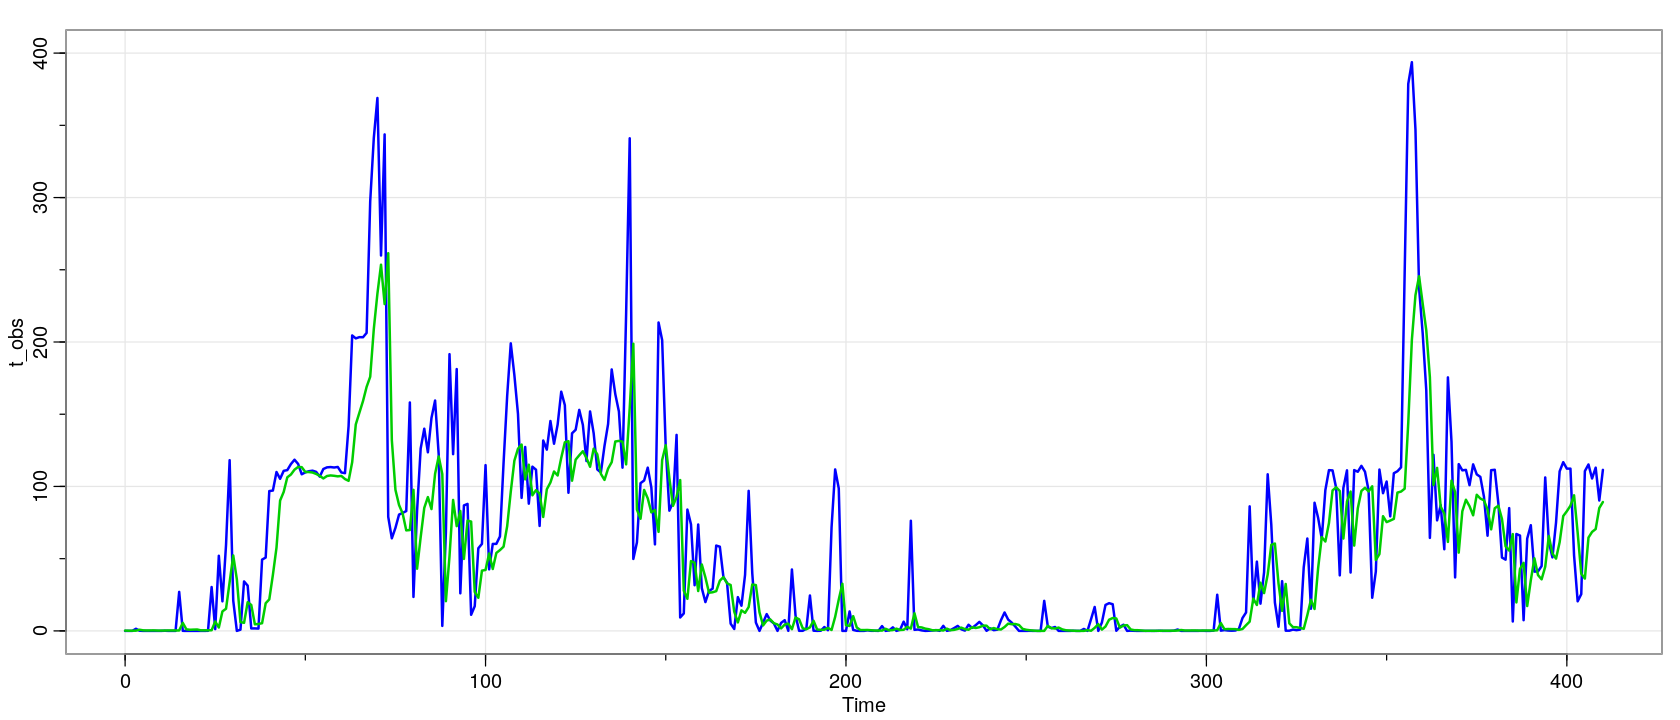

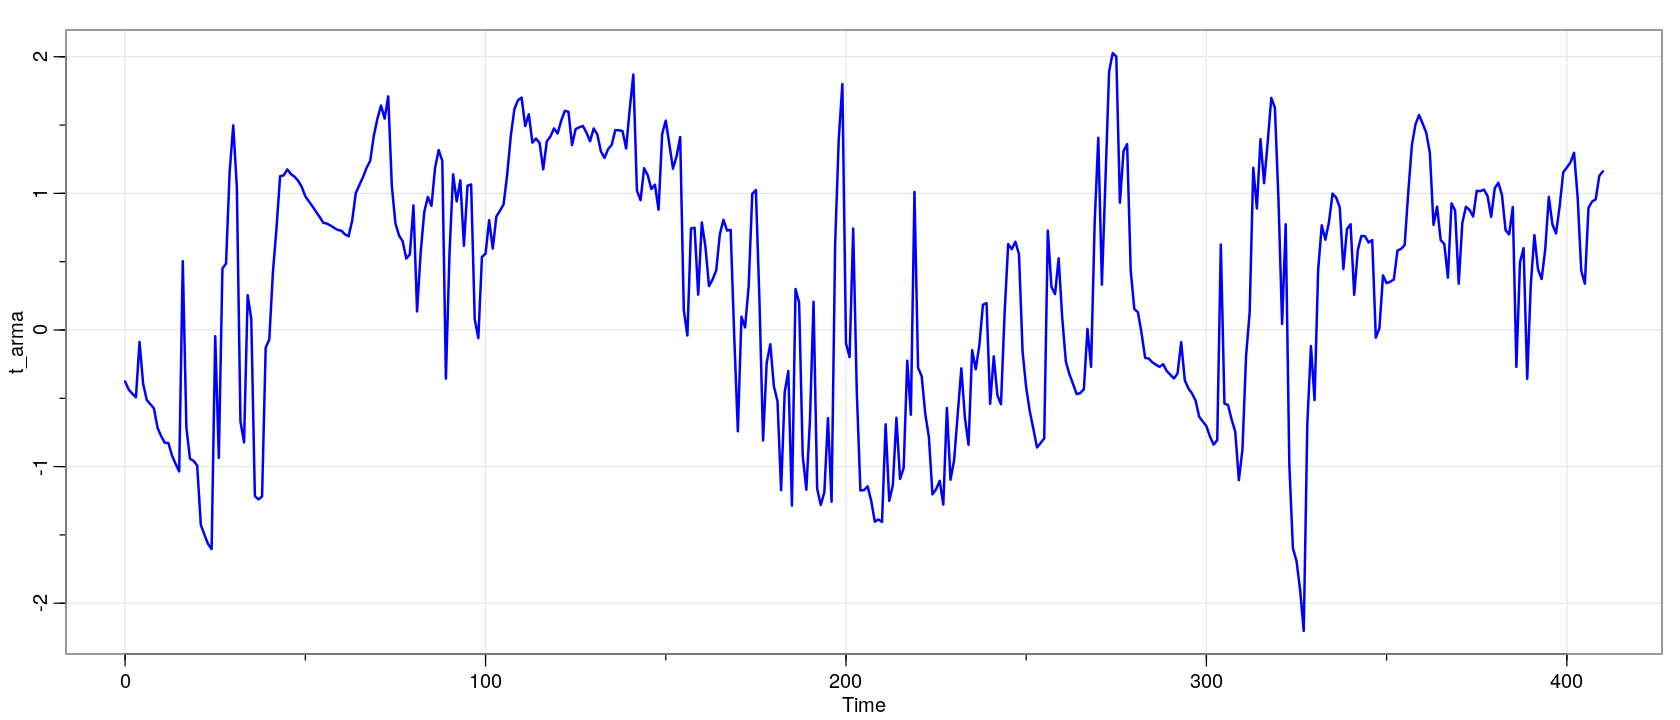

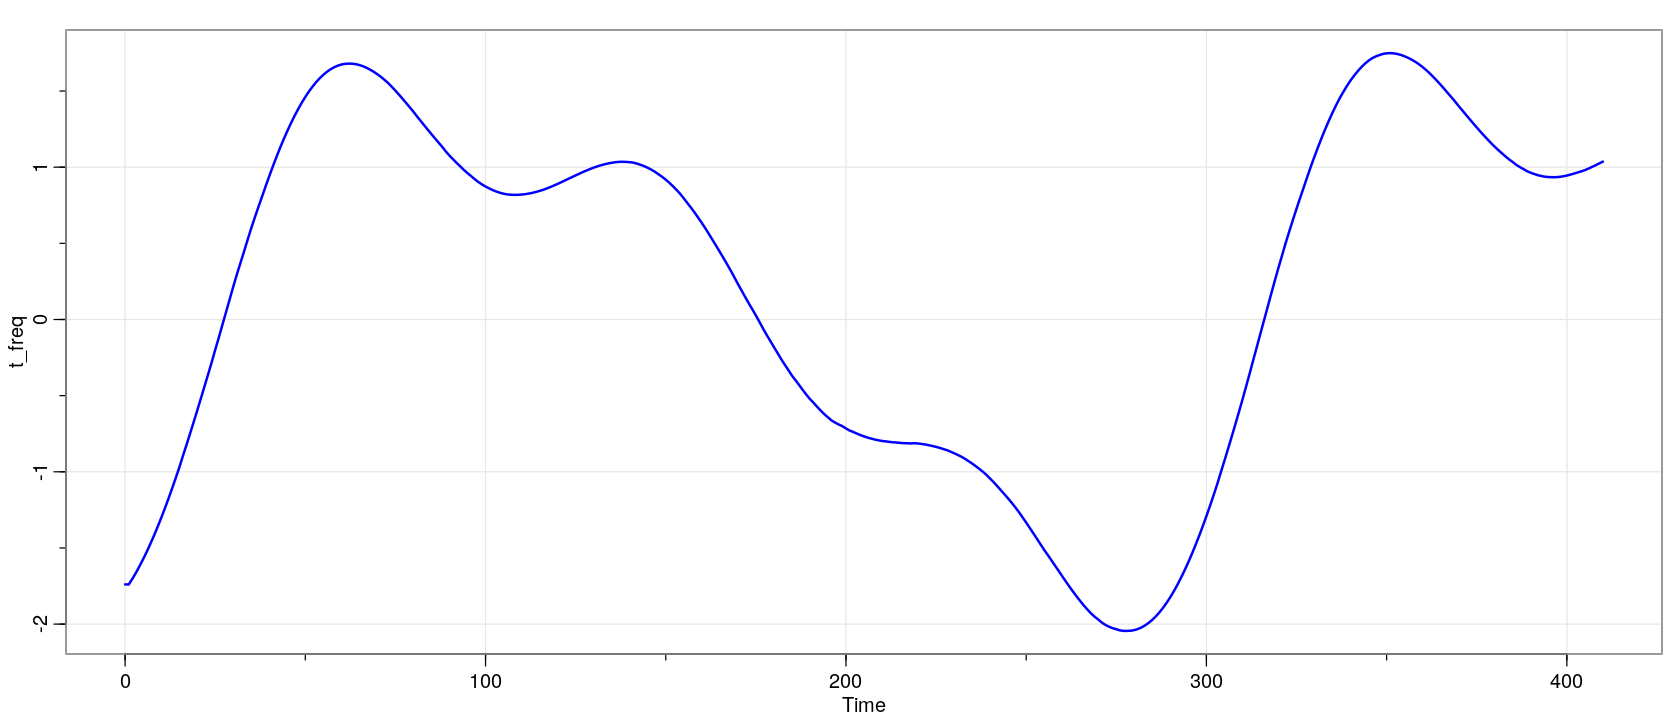

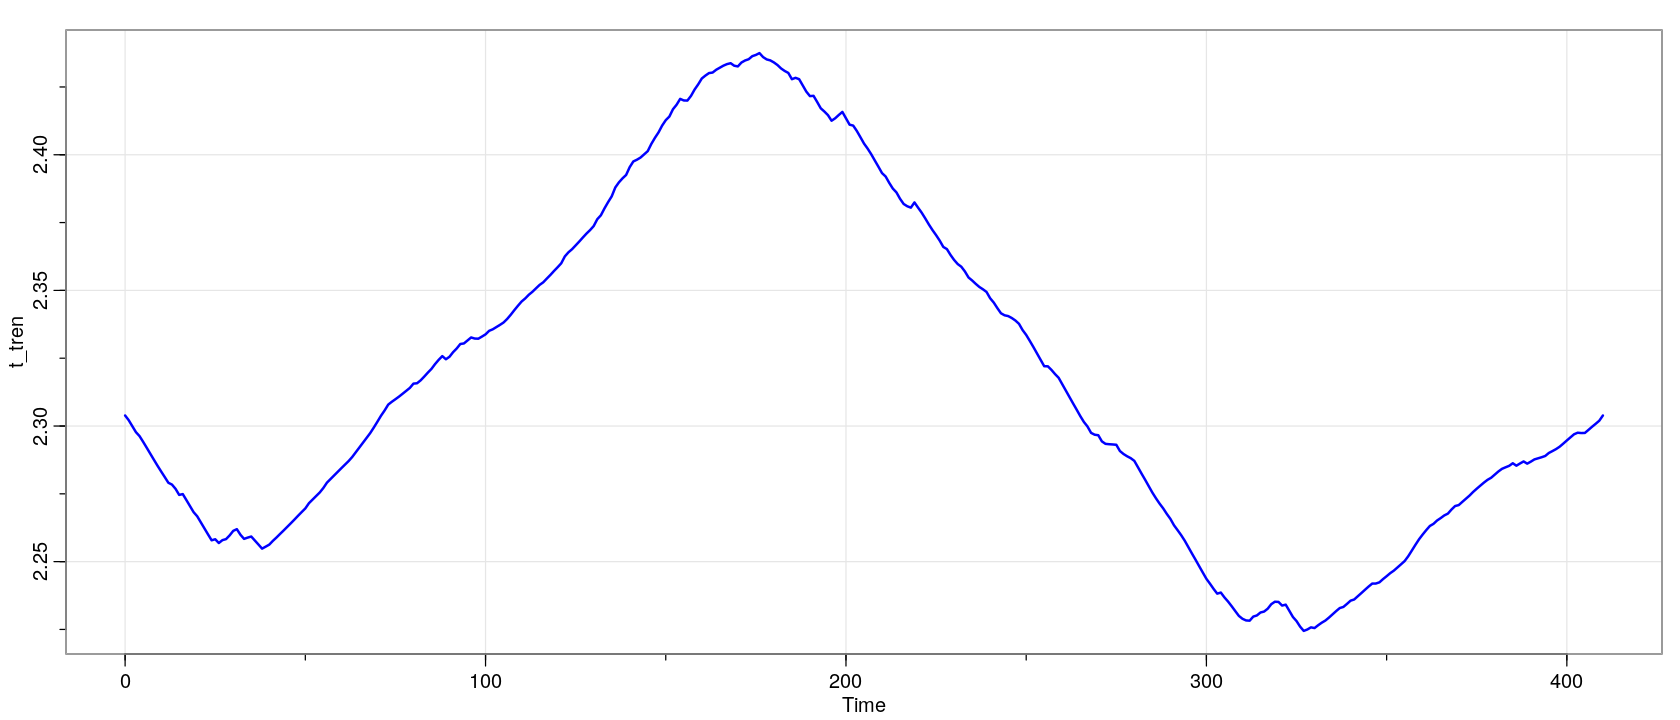

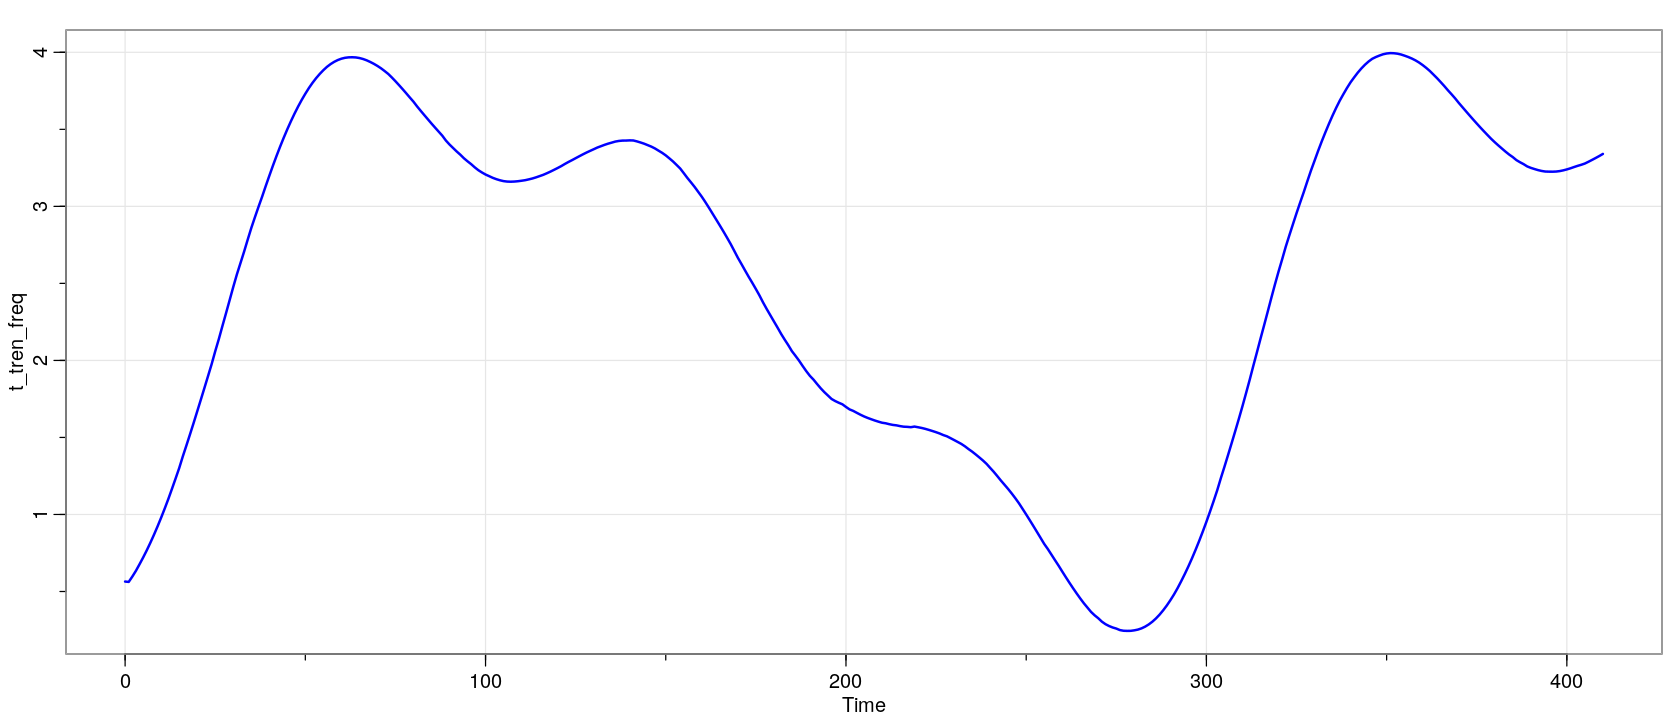

In [26]:
tsplot(t_obs, col=4, lwd=2, ylim=c(0,400))
lines(t_pred, col=3, lwd=2)

tsplot(t_arma, col=4, lwd=2)
tsplot(t_freq, col=4, lwd=2)
tsplot(t_tren, col=4, lwd=2)

tsplot(t_tren_freq, col=4, lwd=2)


In [27]:
Sys.time()

[1] "2021-07-24 17:24:43 -03"

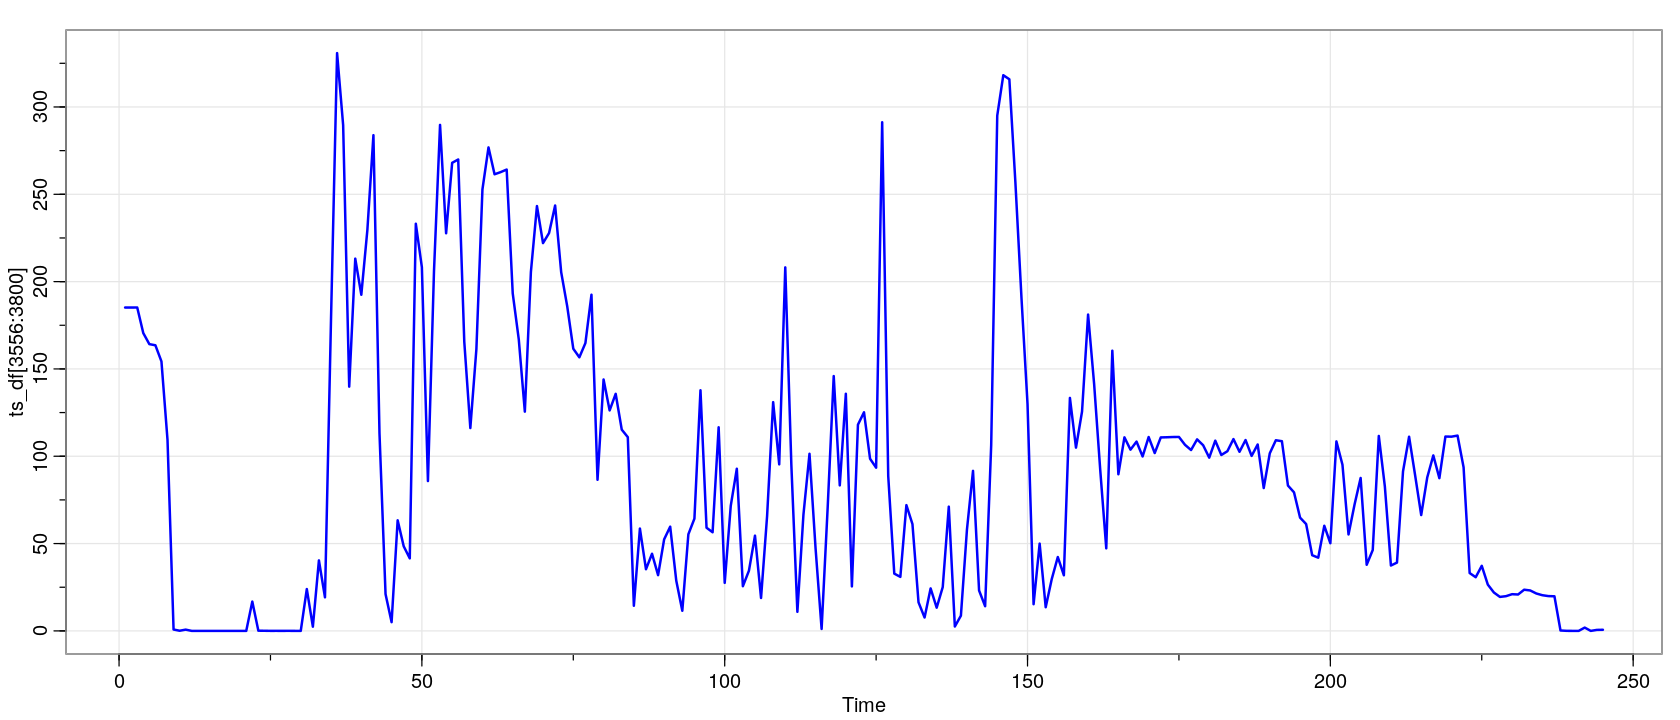

In [28]:
tsplot(ts_df[3556:3800], col=4, lwd=2)